# Effects of perturbations on cytokines 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata
from scipy.stats import fisher_exact
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from copy import deepcopy

mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

import sys
sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *
import yaml
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [3]:
# %%bash
# DATADIR=/mnt/oak/users/emma/data/GWT/
# DROPBOX_PATH=GRNPerturbSeq/3_expts/processed_data/CD4i_final/
# rclone copy "dropbox:${DROPBOX_PATH}" "${DATADIR}/CD4i_final/" --size-only -v


# DATADIR=/mnt/oak/users/emma/data/GWT/
# DROPBOX_PATH=GRNPerturbSeq/3_expts/processed_data/CD4i_final/DE_results_all_confounders/
# rclone copy "dropbox:${DROPBOX_PATH}" "${DATADIR}/CD4i_final/DE_results_all_confounders" \
#   --include "*.csv" --size-only -v

### Load DE data

In [4]:
import anndata
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'

In [5]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

# Filter very lowly expressed genes
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

# Calculate for Rest condition
base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

# Calculate for Stim8hr condition
base_mean_stim8 = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim8.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim8.std(1).fillna(10000)

# Calculate for Stim48hr condition
base_mean_stim48 = base_mean_df[base_mean_df['culture_condition'] == 'Stim48hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim48hr'] = base_mean_stim48.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim48hr'] = base_mean_stim48.std(1).fillna(10000)

# Exclude from analysis genes with very low base mean (messing up reliability estimate)
gs_mask = (adata_de.var['mean_baseMean_Rest'] > 0.1) & (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Stim48hr'] > 0.1)
adata_de = adata_de[:, gs_mask].copy()
sum(~gs_mask)

3677

In [6]:
adata_de_corr = anndata.experimental.read_lazy(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad')
target_contrast_correction_dict = dict(zip(adata_de_corr.obs.to_dataframe()['target_contrast'], adata_de_corr.obs.to_dataframe()['target_contrast_corrected']))
target_contrast_name_correction_dict = dict(zip(adata_de_corr.obs.to_dataframe()['target_contrast_gene_name'], adata_de_corr.obs.to_dataframe()['target_contrast_gene_name_corrected']))

adata_de.obs['target_contrast_gene_name'] = adata_de.obs['target_contrast_gene_name'].map(target_contrast_name_correction_dict)
adata_de.obs['target_contrast'] = adata_de.obs['target_contrast'].map(target_contrast_correction_dict)

In [7]:
# remove missing perturb
adata_de = adata_de[~adata_de.obs['target_contrast_gene_name'].isna()].copy()

In [8]:
adata_de.var_names = adata_de.var['gene_name'].values
de_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
de_stats.head()

target_contrast target_name condition  n_cells_target  n_up_genes  \
0  ENSG00000012963        UBR7   Stim8hr           491.0           0   
1  ENSG00000017260      ATP2C1   Stim8hr           469.0           0   
2  ENSG00000067606       PRKCZ   Stim8hr           427.0           1   
3  ENSG00000092929      UNC13D   Stim8hr           830.0           0   
4  ENSG00000100504        PYGL   Stim8hr           414.0           1   

   n_down_genes  n_total_de_genes  ontarget_effect_size  ontarget_significant  \
0             2                 2            -12.952742                  True   
1             1                 1            -16.307246                  True   
2             1                 2             -1.658755                 False   
3             2                 2            -19.259466                  True   
4             0                 1              0.000000                 False   

     baseMean  offtarget_flag n_total_genes_category ontarget_effect_category  \
0   43.169196            True          2-10 DE genes             on-target KD   
1  102.399025           False              1 DE gene             on-target KD   
2    0.965897           False          2-10 DE genes          no on-target KD   
3   60.904483           False          2-10 DE genes             on-target KD   
4         NaN           False              1 DE gene          no on-target KD   

  target_contrast_corrected                obs_names target_name_corrected  
0           ENSG00000012963  ENSG00000012963_Stim8hr                  UBR7  
1           ENSG00000017260  ENSG00000017260_Stim8hr                ATP2C1  
2           ENSG00000067606  ENSG00000067606_Stim8hr                 PRKCZ  
3           ENSG00000092929  ENSG00000092929_Stim8hr                UNC13D  
4           ENSG00000100504  ENSG00000100504_Stim8hr                  PYGL

<Axes: >

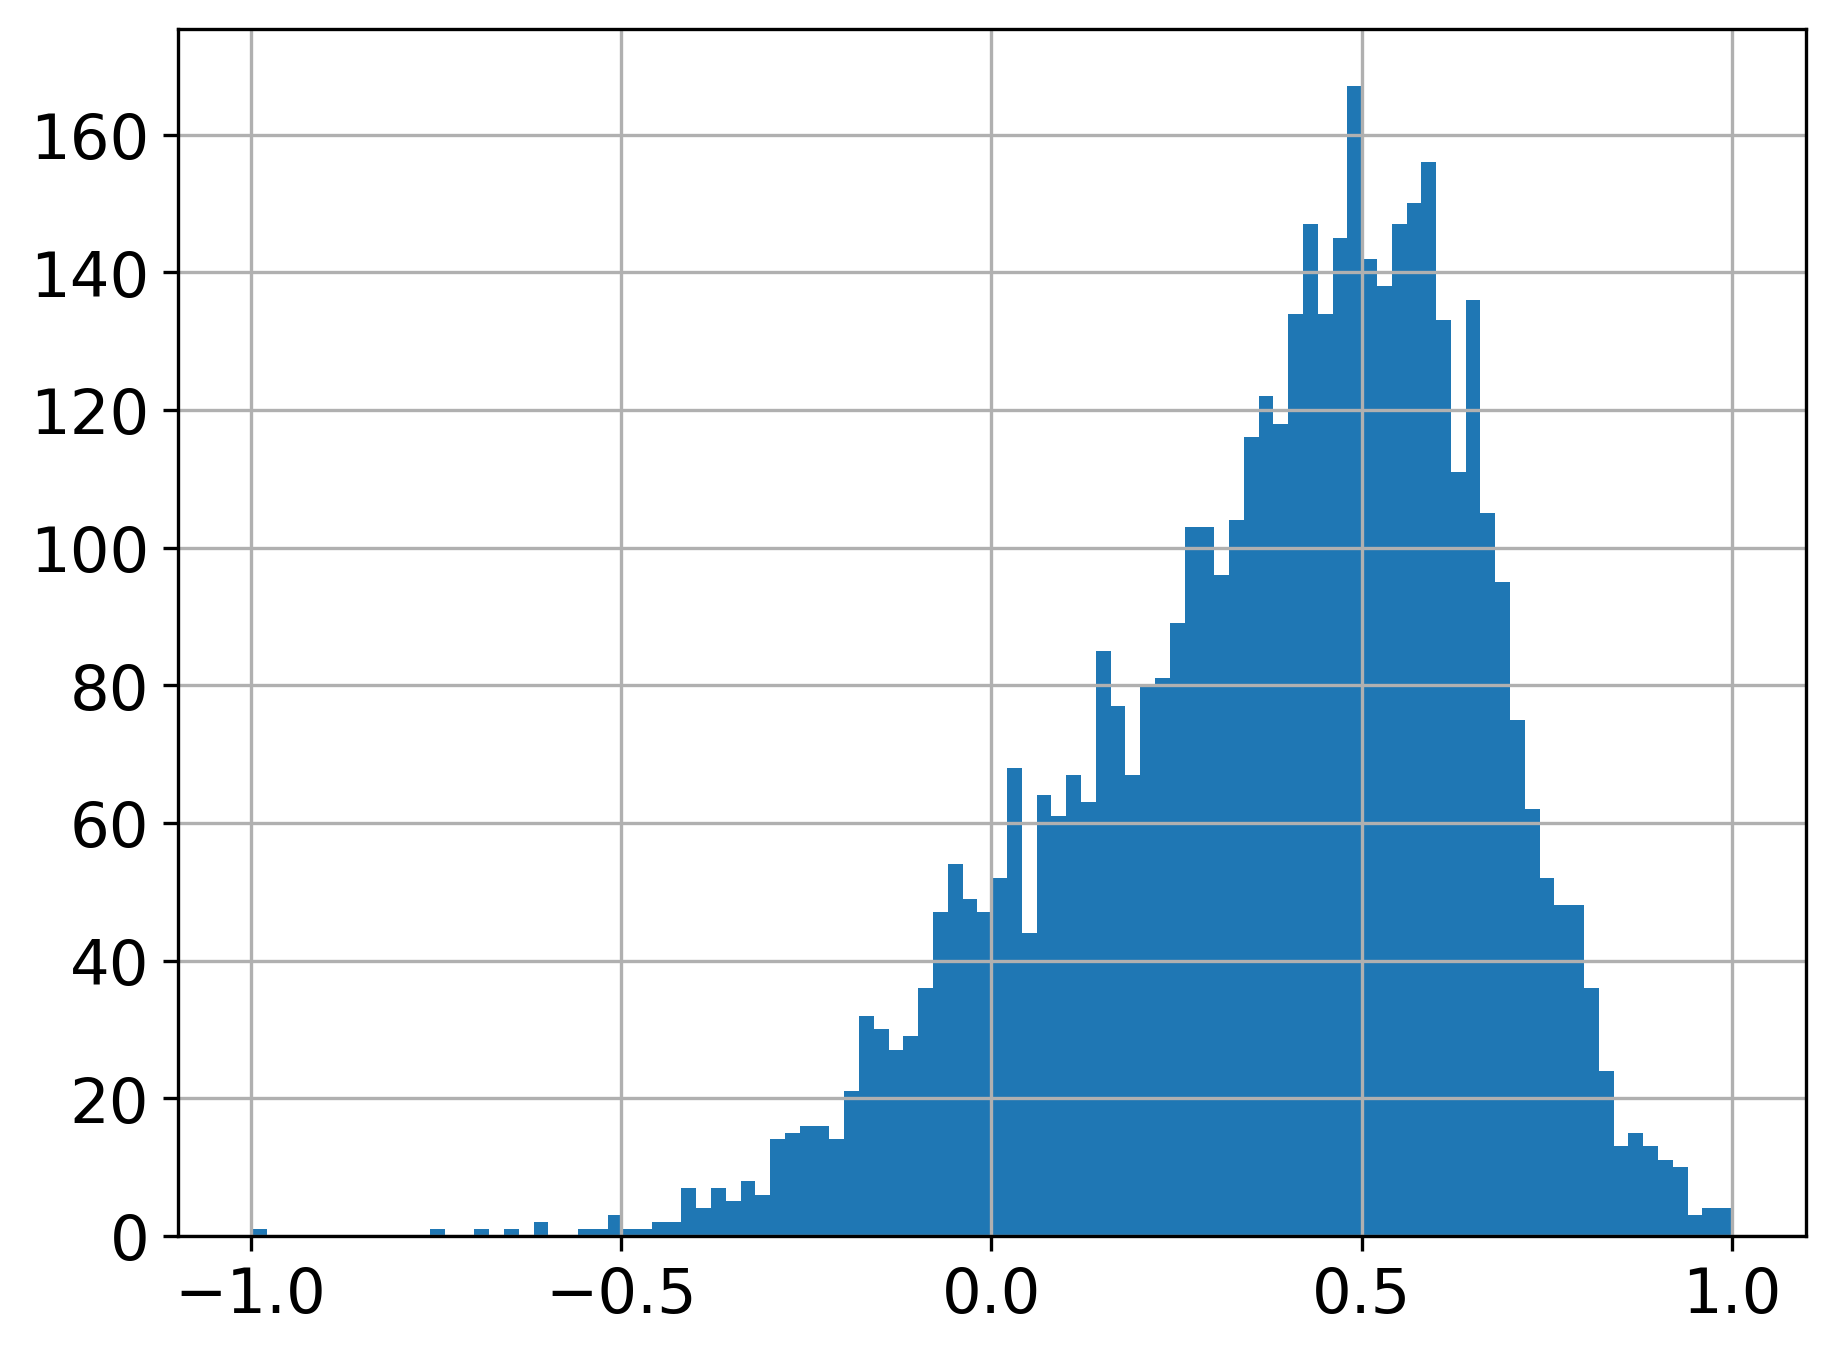

In [9]:
donor_robustness_summary = pd.read_csv('../3_DE_analysis/results/DE_donor_robustness_correlation_summary.csv', index_col=0)
donor_robustness_summary['donor_correlation_mean'].hist(bins=100)

Exclude regulators with less robust responses across donors

In [10]:
donor_corr_conditions = donor_robustness_summary.pivot(index='target_name', values='donor_correlation_mean', columns='condition')
remove_perturbs = donor_corr_conditions[~(donor_corr_conditions.fillna(1) > 0.05).any(axis=1)].index.tolist()

adata_de = adata_de[~adata_de.obs['target_contrast_gene_name'].isin(remove_perturbs)].copy()
adata_de

AnnData object with n_obs × n_vars = 33881 × 10282
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name', 'mean_baseMean_Rest', 'std_baseMean_Rest', 'mean_baseMean_Stim8hr', 'std_baseMean_Stim8hr', 'mean_baseMean_Stim48hr', 'std_baseMean_Stim48hr'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

## Cytokines

In [156]:
## Read list of cytokines
# cytokines = pd.read_table('../../metadata/gene_lists/cytokines.tsv', header=None)[0].tolist()
# cytokines = [x for x in cytokines if x.startswith("TNF") or x.startswith("IL") or x.startswith("IN") or x.startswith("CXCL") or x.startswith("CD") or x.startswith("CC")]

immune_genes_df = pd.read_csv('../../metadata/immune_effector_genes.csv')
cytokines = immune_genes_df[immune_genes_df['Category'] == 'Cytokine']['gene_name'].tolist()

exclude = ['IL17F', 'IL6'] 
cytokines = [x for x in cytokines if x not in exclude]
len(cytokines)

34

In [157]:
cytokines_de_df = get_DE_results_long(adata_de, genes=cytokines, effect_estimates=['zscore', 'log_fc', 'baseMean'])
cytokines_de_df['target_condition'] = cytokines_de_df['target_contrast_gene_name'].astype(str) + '_' +  cytokines_de_df['culture_condition'].astype(str)
# Exclude on target
cytokines_de_df = cytokines_de_df[cytokines_de_df['gene_name'] != cytokines_de_df['target_contrast_gene_name']]


1786


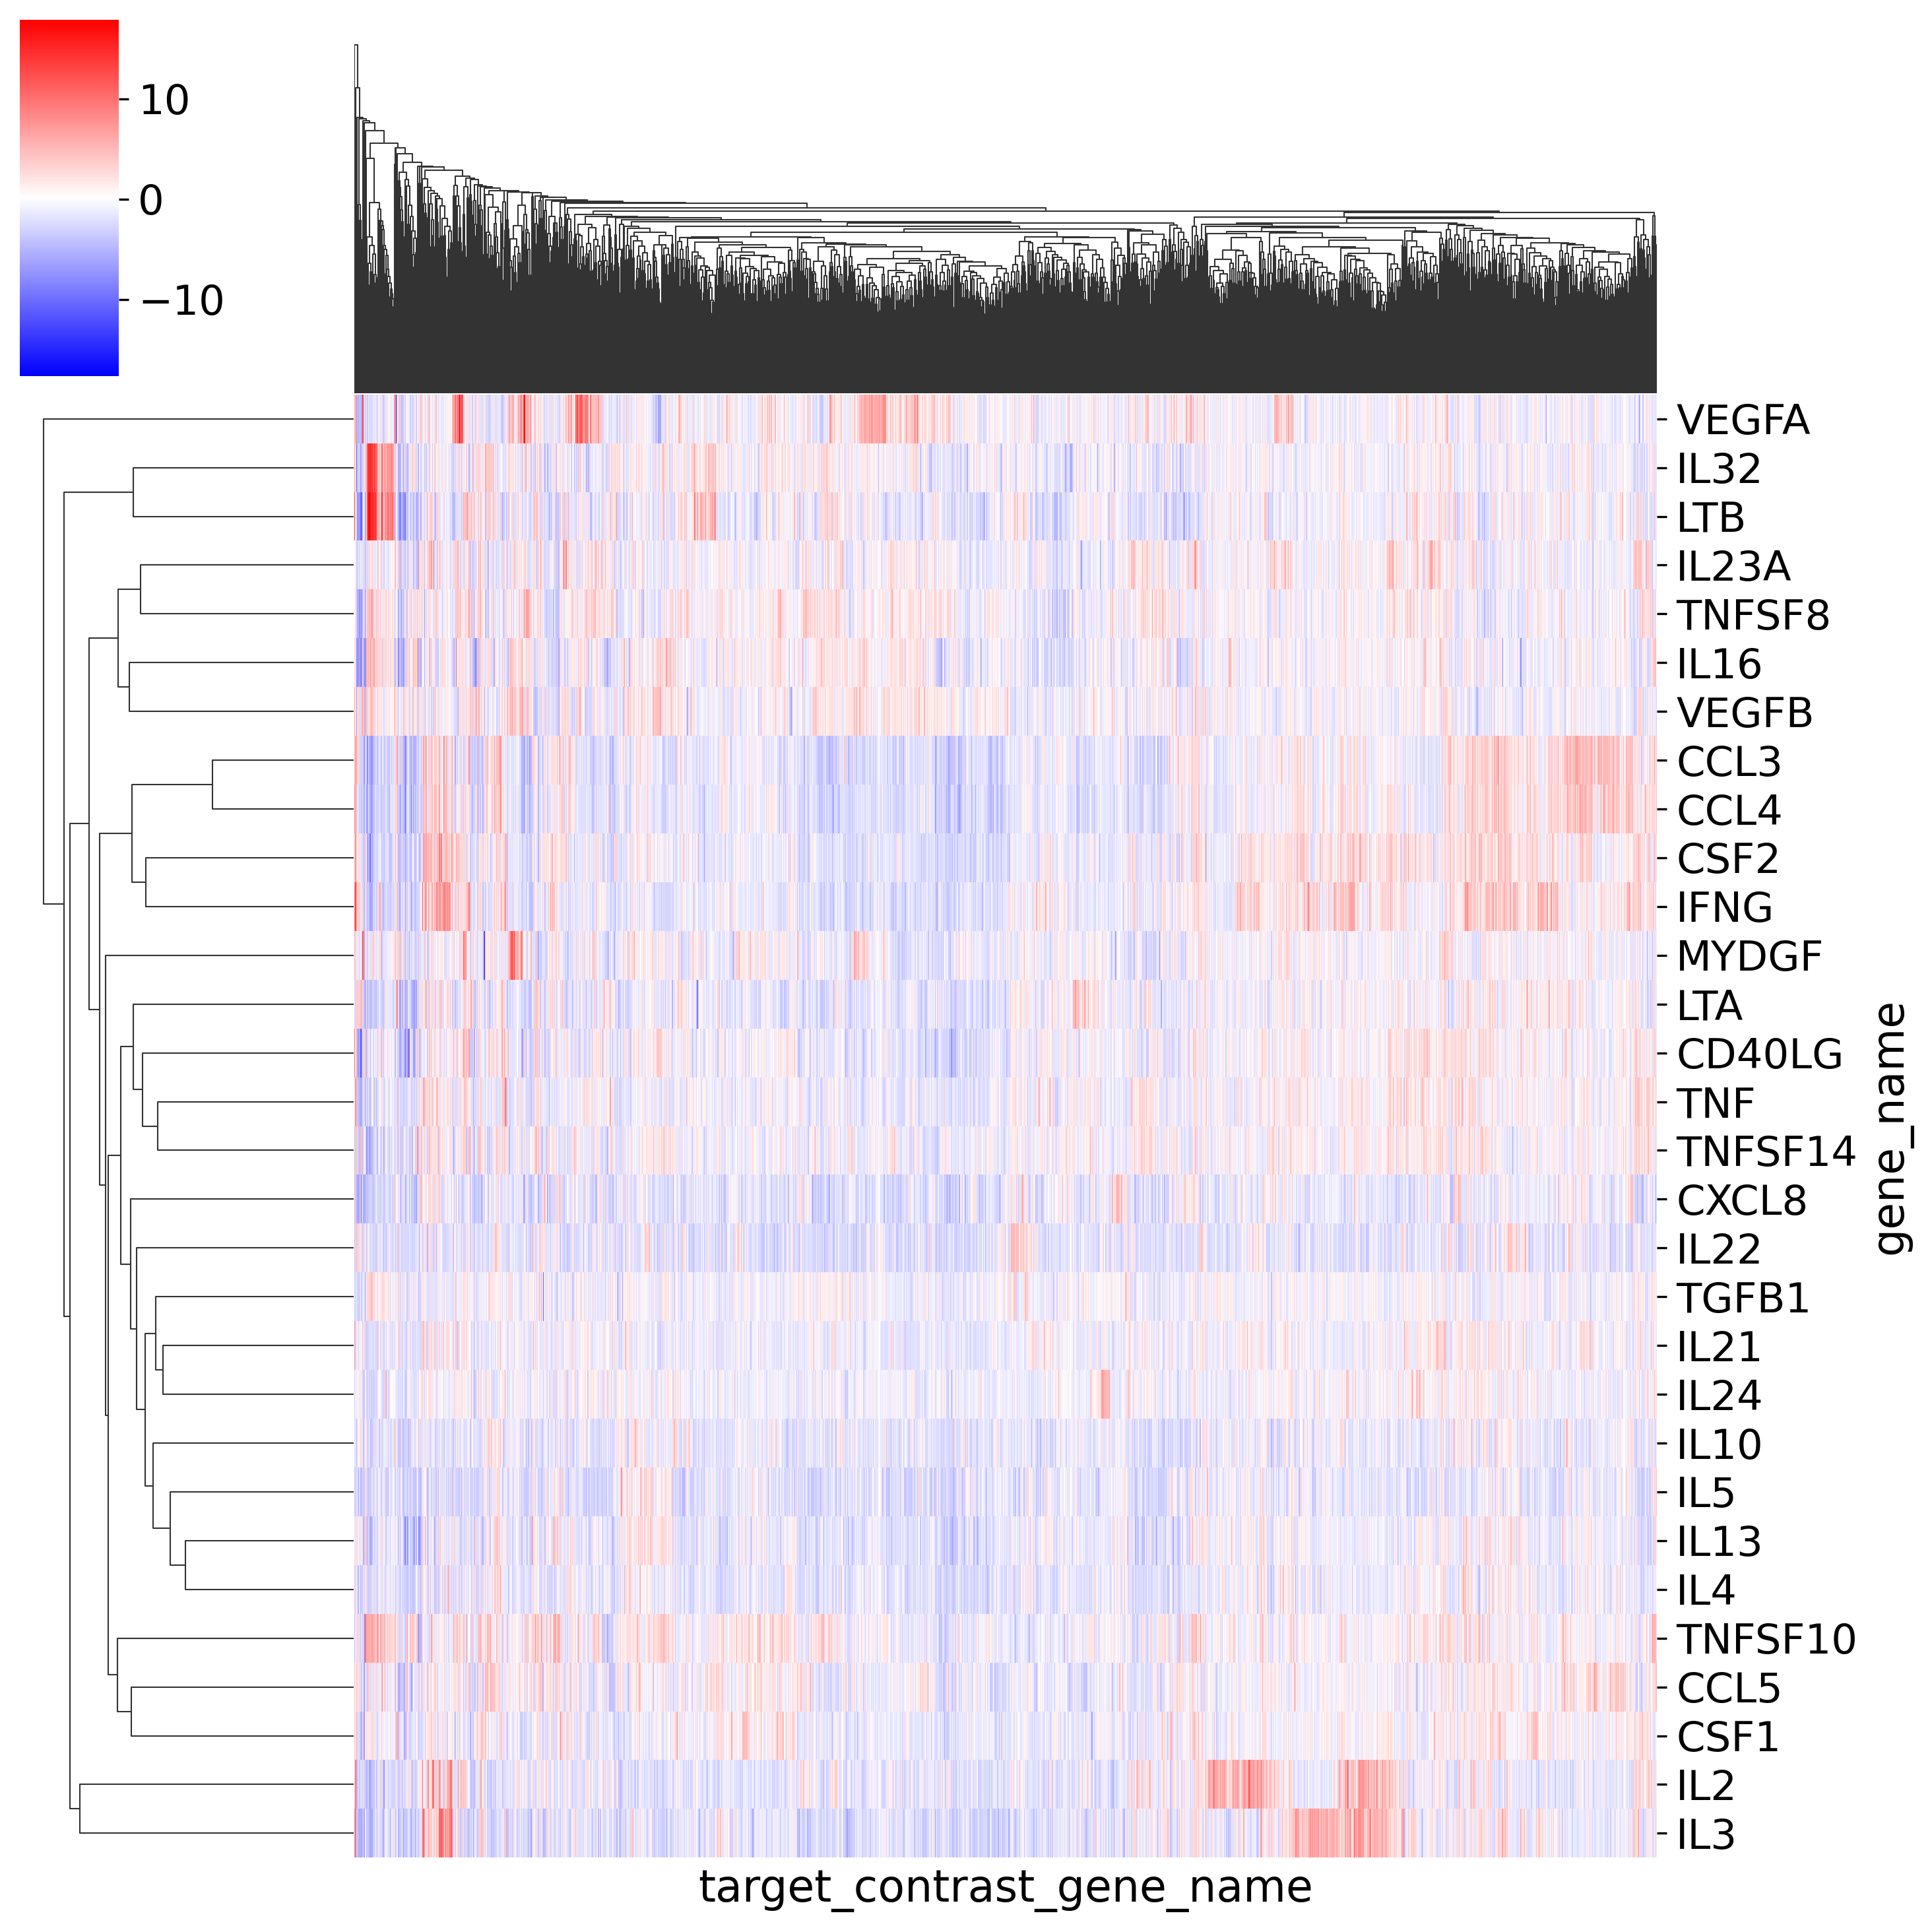

In [158]:
# Get signif regulators in at least one condition
unique_regulators = cytokines_de_df[cytokines_de_df['adj_p_value'] < 0.01]['target_contrast_gene_name'].unique()

print(len(unique_regulators))

filtered_df = cytokines_de_df[cytokines_de_df['target_contrast_gene_name'].isin(unique_regulators)]
filtered_df['effect_size'] = filtered_df['zscore'].abs()
all_genes = filtered_df['gene_name'].unique()

# Create pivot table with strongest effect across conditions (to cluster regulators for viz)
top_filtered_df = filtered_df.loc[filtered_df.groupby(['target_contrast_gene_name', 'gene_name'], observed=True)['effect_size'].idxmax()]
# top_filtered_df.loc[~top_filtered_df['significant'], 'zscore'] = 0
pl_df = top_filtered_df.pivot(index='gene_name', columns=['target_contrast_gene_name'], values='zscore').fillna(0)

# Get clustered regulators order without plotting
g = sns.clustermap(pl_df, xticklabels=False, yticklabels=True, cmap='bwr')
unique_regulators_order = pl_df.columns[g.dendrogram_col.reordered_ind].tolist()
all_genes_order = pl_df.index[g.dendrogram_row.reordered_ind].tolist()
# plt.close()
assert pd.Series(unique_regulators).isin(unique_regulators_order).all()
assert pd.Series(all_genes).isin(all_genes_order).all()

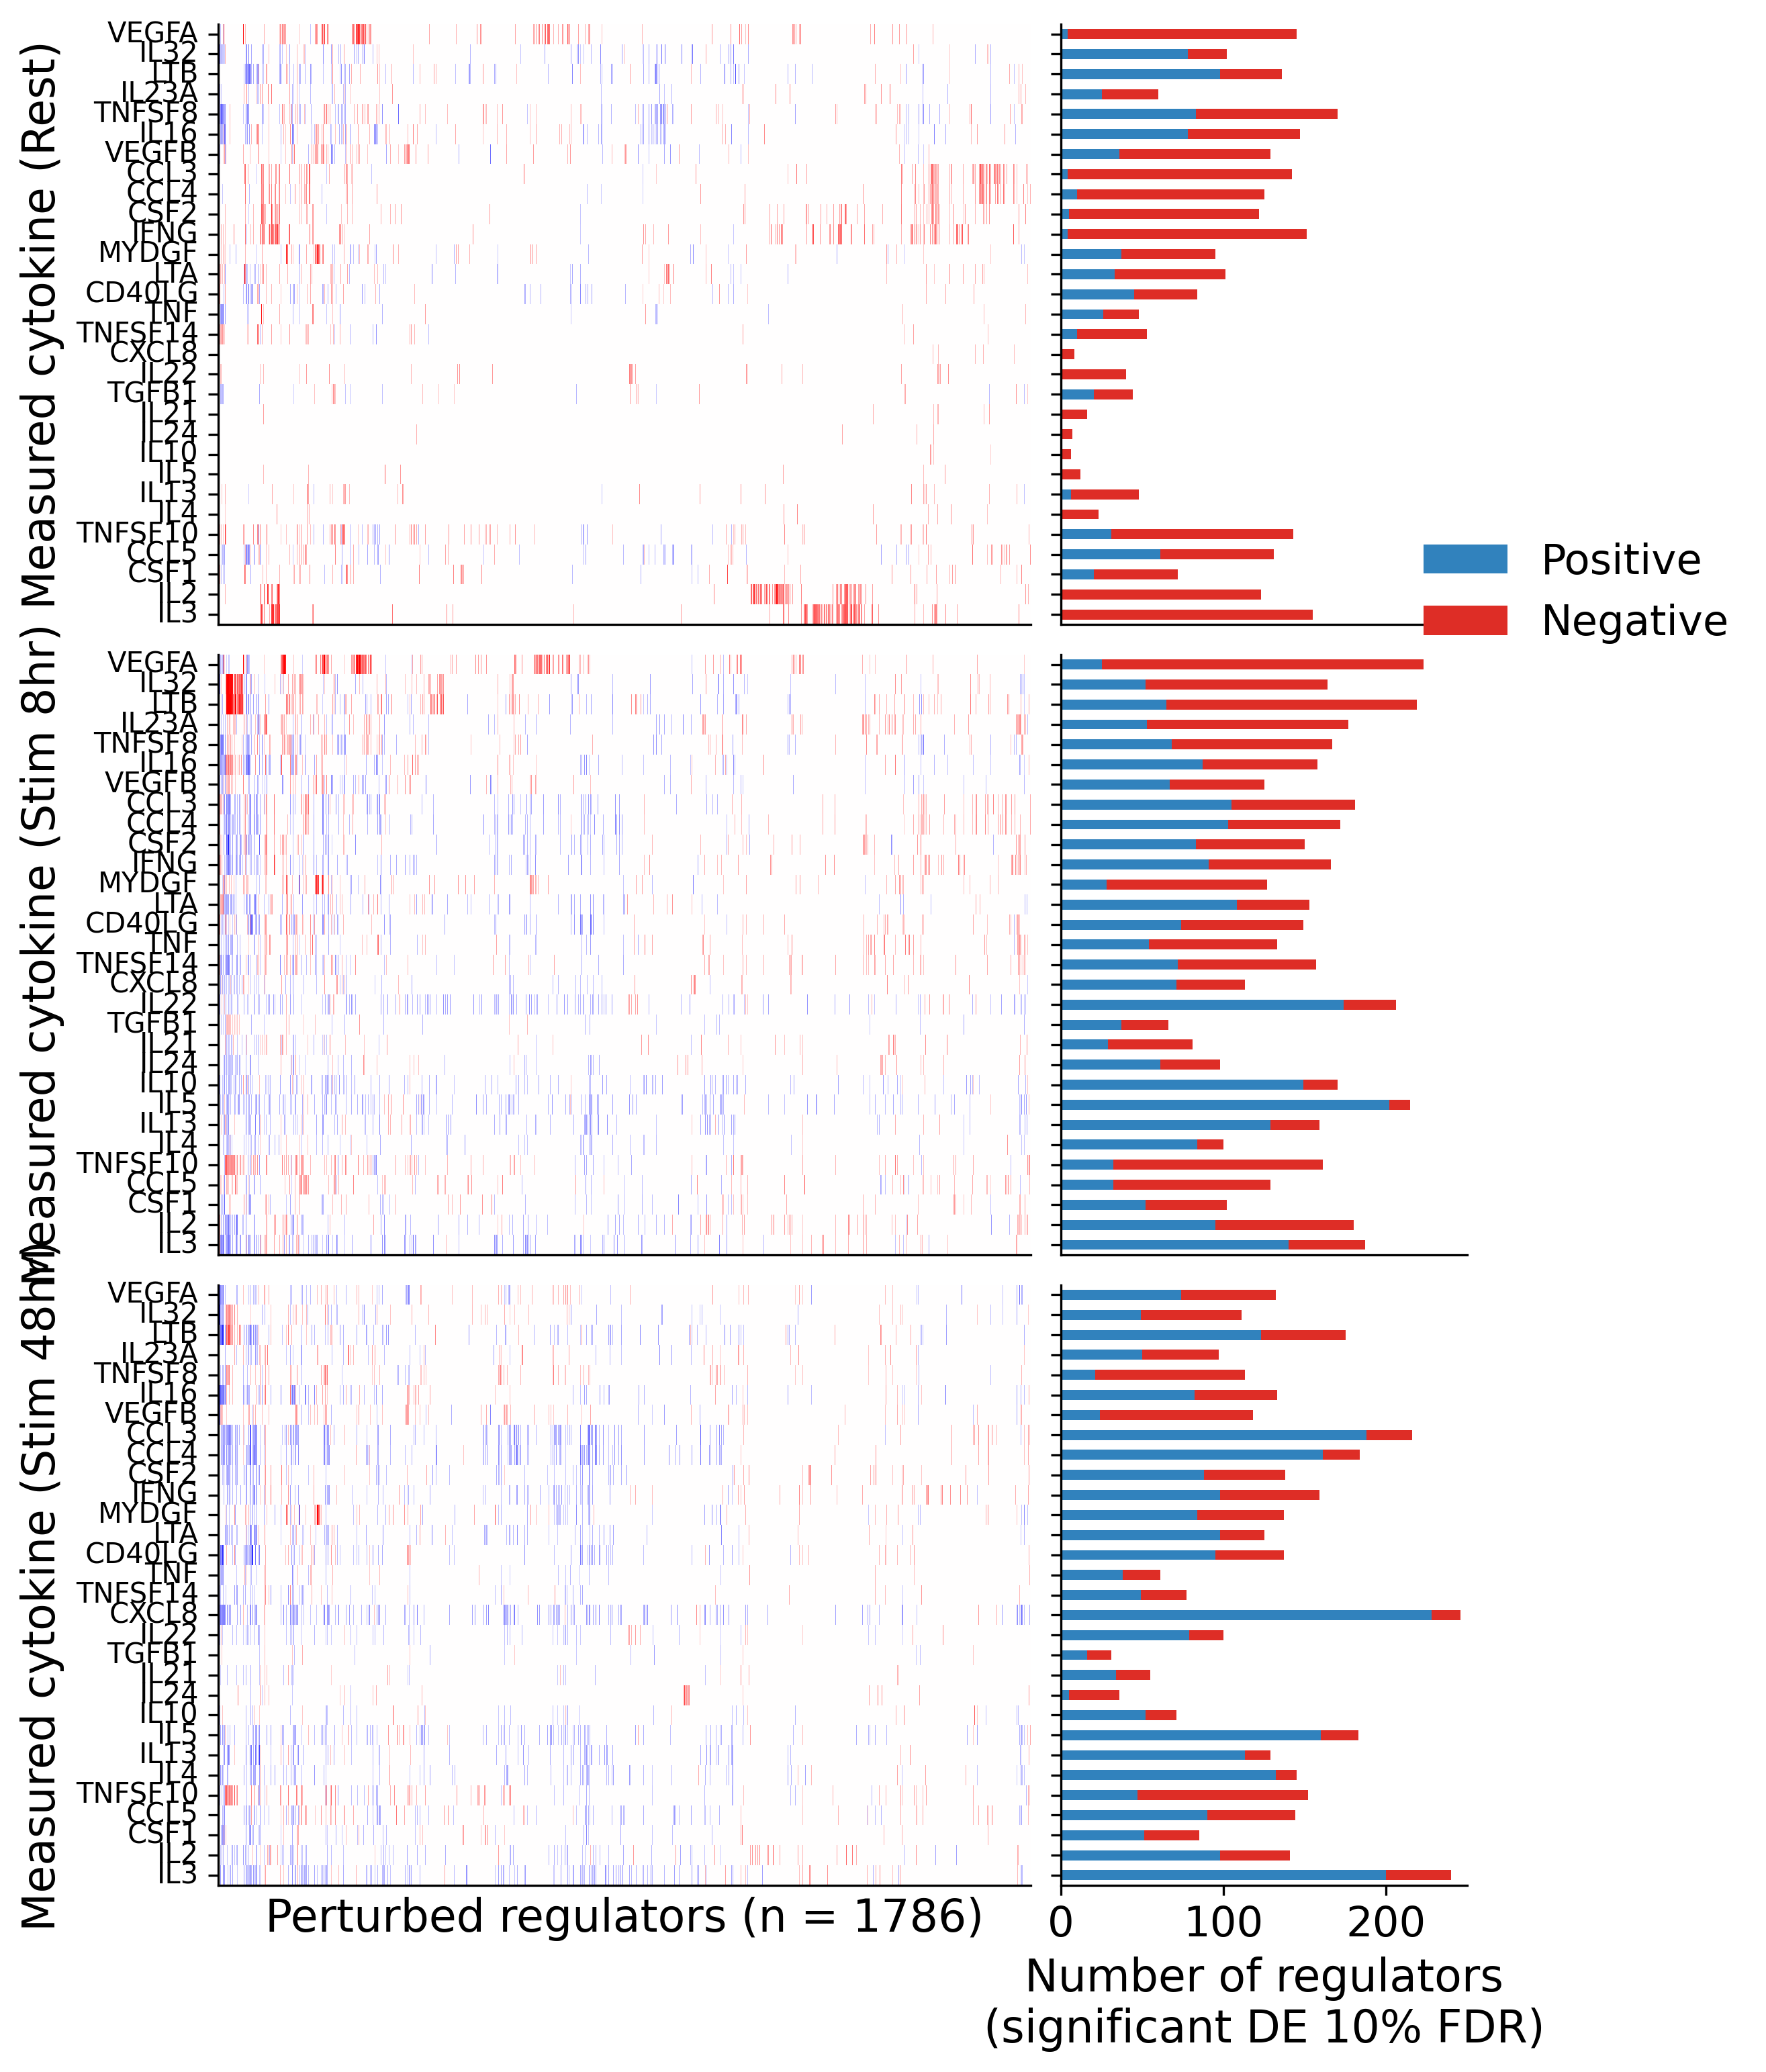

In [159]:
# Show only significant effects
filtered_df.loc[~filtered_df['significant'], 'zscore'] = 0

# Create pivot tables with explicit index and columns to ensure same shape
rest_pl_df = filtered_df[filtered_df['culture_condition'] == 'Rest'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0)

stim8hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim8hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0)

stim48hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim48hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0)

# Get counts of positive and negative regulators for each cytokine
def get_regulator_counts(df, condition):
    # Filter for condition and get direction of regulation
    # Count positive and negative regulators directly from wide matrix
    reg_counts = pd.DataFrame(index=df.index)
    reg_counts['Positive'] = (df < 0).sum(axis=1)  # Positive regulators have negative zscores
    reg_counts['Negative'] = (df > 0).sum(axis=1)  # Negative regulators have positive zscores
    
    # Ensure index matches expected order
    reg_counts = reg_counts.reindex(all_genes_order, fill_value=0)
    return reg_counts

# Get counts for each condition
reg_counts_rest = get_regulator_counts(rest_pl_df, 'Rest')
reg_counts_8hr = get_regulator_counts(stim8hr_pl_df, 'Stim8hr') 
reg_counts_48hr = get_regulator_counts(stim48hr_pl_df, 'Stim48hr')

# Create figure with 3 rows and 2 columns
y_labelsize = 10
fig = plt.figure(figsize=(8,12))
gs = fig.add_gridspec(3, 2, width_ratios=[2, 1], wspace=0.05, hspace=0.05)

# Define colors for consistent mapping
color_dict = {'Positive': '#3182bd', 'Negative': '#de2d26'}

# Rest condition heatmap
ax1 = fig.add_subplot(gs[0,0])
sns.heatmap(rest_pl_df, center=0, cmap='bwr', vmax=12, vmin=-12, cbar=False, xticklabels=False, yticklabels=True, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Measured cytokine (Rest)')
ax1.tick_params(axis='y', labelsize=y_labelsize)  # Reduce y-tick label size

# Rest condition barplot
ax2 = fig.add_subplot(gs[0,1])
reg_counts_rest.iloc[::-1].reindex(columns=['Positive', 'Negative']).plot(
    kind='barh', stacked=True, ax=ax2, color=[color_dict['Positive'], color_dict['Negative']])
ax2.set_ylabel('')  # Hide y-label since we removed ticks
ax2.set_xlabel('')  # Hide x-label since it's only shown on bottom
ax2.set_xlim(0, 250)
ax2.xaxis.set_visible(False)  # Hide x-axis
ax2.set_yticklabels([])  # Remove y-tick labels
# Add legend only to top plot
ax2.legend(labels={"Positive":'Positive regulator', "Negative":'Negative regulator'}, bbox_to_anchor=(0.8, 0.2), frameon=False)

# Stim8hr condition heatmap
ax3 = fig.add_subplot(gs[1,0])
sns.heatmap(stim8hr_pl_df, center=0, cmap='bwr', vmax=12, vmin=-12, cbar=False, xticklabels=False, yticklabels=True, ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('Measured cytokine (Stim 8hr)')
ax3.tick_params(axis='y', labelsize=y_labelsize)  # Reduce y-tick label size

# Stim8hr condition barplot
ax4 = fig.add_subplot(gs[1,1])
reg_counts_8hr.iloc[::-1].reindex(columns=['Positive', 'Negative']).plot(
    kind='barh', stacked=True, ax=ax4, color=[color_dict['Positive'], color_dict['Negative']])
ax4.set_ylabel('')  # Hide y-label since we removed ticks
ax4.set_xlabel('')  # Hide x-label since it's only shown on bottom
ax4.set_xlim(0, 250)
ax4.xaxis.set_visible(False)  # Hide x-axis
ax4.set_yticklabels([])  # Remove y-tick labels
ax4.get_legend().remove()  # Remove legend

# Stim48hr condition heatmap
ax5 = fig.add_subplot(gs[2,0])
sns.heatmap(stim48hr_pl_df, center=0, cmap='bwr', vmax=12, vmin=-12, cbar=False, xticklabels=False, yticklabels=True, ax=ax5)
ax5.set_xlabel(f'Perturbed regulators (n = {stim48hr_pl_df.shape[1]})')
ax5.set_ylabel('Measured cytokine (Stim 48hr)')
ax5.tick_params(axis='y', labelsize=y_labelsize)  # Reduce y-tick label size

# Stim48hr condition barplot
ax6 = fig.add_subplot(gs[2,1])
reg_counts_48hr.iloc[::-1].reindex(columns=['Positive', 'Negative']).plot(
    kind='barh', stacked=True, ax=ax6, color=[color_dict['Positive'], color_dict['Negative']])
ax6.set_ylabel('')  # Hide y-label since we removed ticks
ax6.set_xlabel('Number of regulators\n(significant DE 10% FDR)')  # Show x-label only on bottom plot
ax6.set_xlim(0, 250)
ax6.set_yticklabels([])  # Remove y-tick labels
ax6.get_legend().remove()  # Remove legend

# Adjust layout
sns.despine()
plt.tight_layout()


In [160]:
# Combine pivot tables vertically 
rest_pl_df['condition'] = 'Rest'
stim8hr_pl_df['condition'] = 'Stim8hr'
stim48hr_pl_df['condition'] = 'Stim48hr'
combined_pl_df = pd.concat([rest_pl_df, stim8hr_pl_df, stim48hr_pl_df])
combined_pl_df = combined_pl_df.reset_index().sort_values(['gene_name', 'condition'], key=lambda x: pd.Categorical(x, categories=all_genes_order + ['Rest', 'Stim8hr', 'Stim48hr'], ordered=True)).set_index(['gene_name', 'condition'])
row_names = combined_pl_df.reset_index()[['gene_name', 'condition']].assign(gene_condition=lambda x: x['gene_name'] + '_' + x['condition'])['gene_condition'].values

# # Combine pivot tables vertically 
# combined_pl_df = pd.concat([rest_pl_df, stim8hr_pl_df, stim48hr_pl_df])

# Combine regulator counts vertically
reg_counts_rest['condition'] = 'Rest'
reg_counts_8hr['condition'] = 'Stim8hr'
reg_counts_48hr['condition'] = 'Stim48hr'
combined_reg_counts = pd.concat([reg_counts_rest, reg_counts_8hr, reg_counts_48hr])
combined_reg_counts = combined_reg_counts.reset_index().sort_values(['gene_name', 'condition'], key=lambda x: pd.Categorical(x, categories=all_genes_order + ['Rest', 'Stim8hr', 'Stim48hr'], ordered=True)).set_index(['gene_name', 'condition'])

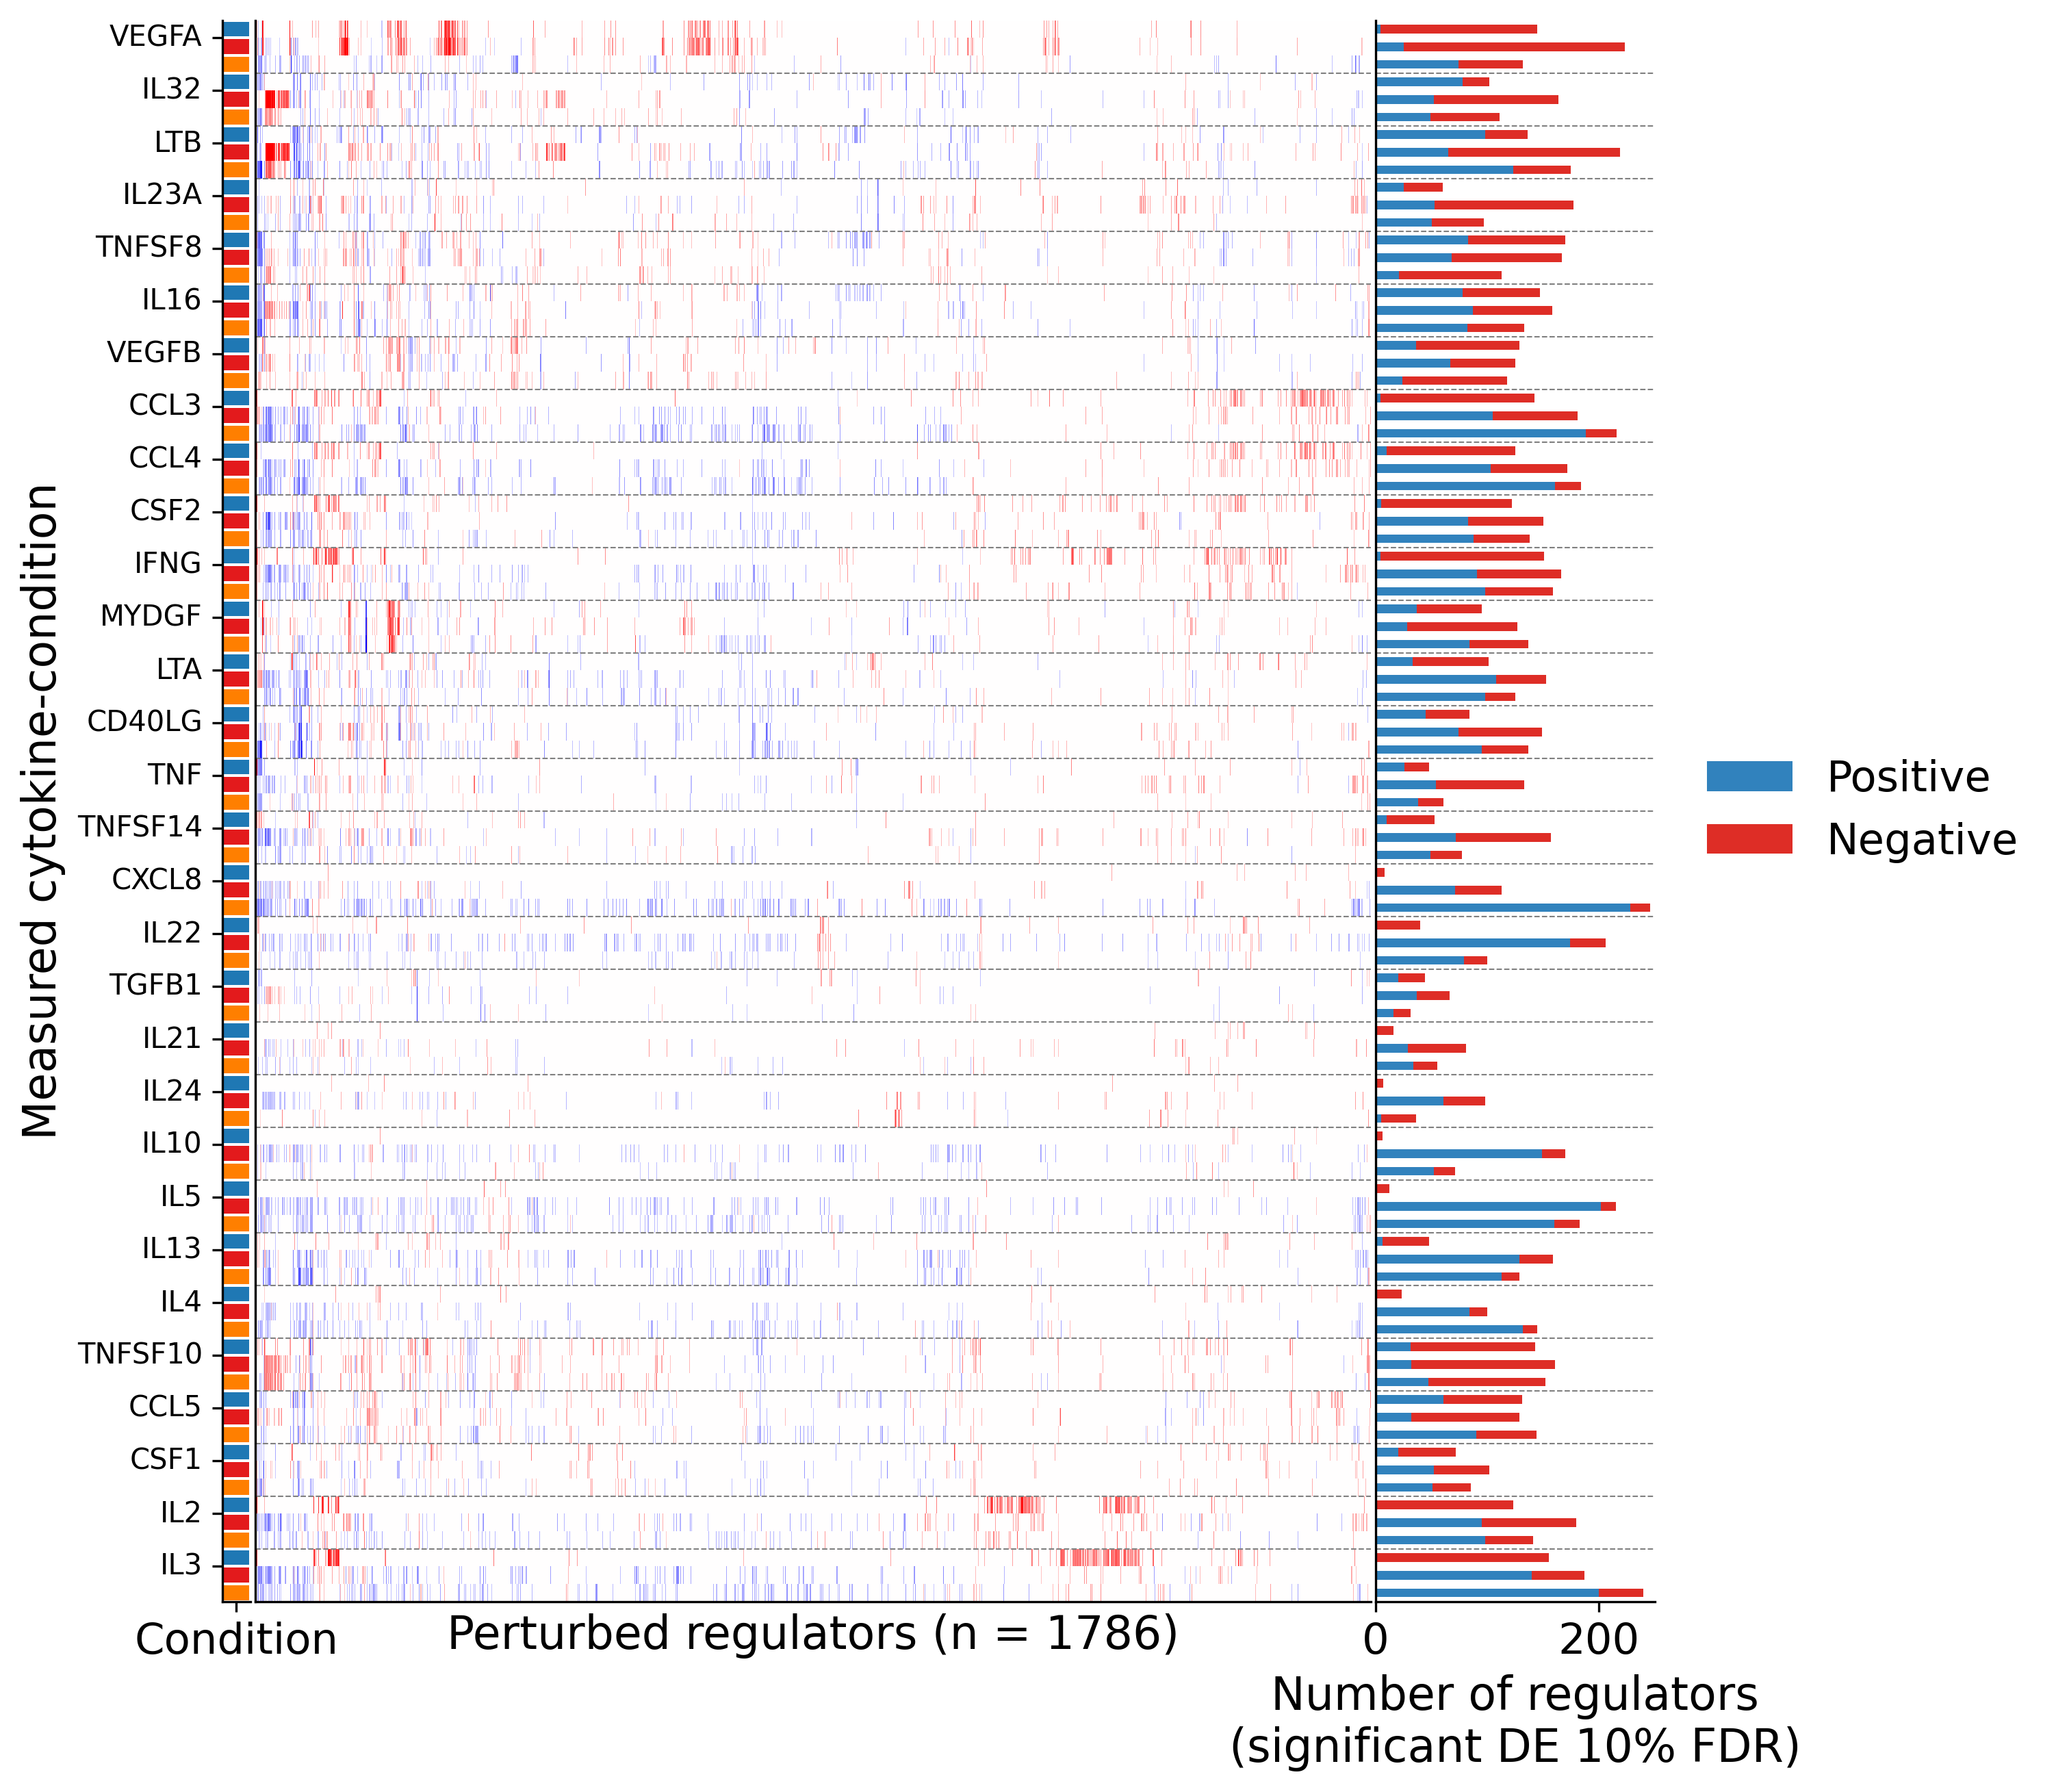

In [287]:
from matplotlib.colors import ListedColormap

# Combine heatmaps and bar plots vertically for each condition


# Create figure with 3 columns and 1 row
y_labelsize = 10
fig = plt.figure(figsize=(9,10))  # Slightly wider to accommodate row colors
gs = fig.add_gridspec(1, 3, width_ratios=[0.05, 2, 0.5], wspace=0.01)

# Define colors for consistent mapping
color_dict = {'Positive': '#3182bd', 'Negative': '#de2d26'}

# Prepare row annotations for culture condition
row_colors = [palettes['culture_condition'][condition] 
              for gene in all_genes_order 
              for condition in ['Rest', 'Stim8hr', 'Stim48hr']]


# # Row color subplot
ax_colors = fig.add_subplot(gs[0,0])
# Convert conditions to categorical codes
condition_mapping = {condition: code for code, condition in enumerate(['Rest', 'Stim8hr', 'Stim48hr'])}
row_color_df = pd.DataFrame({
    'condition': [condition for gene in all_genes_order for condition in ['Rest', 'Stim8hr', 'Stim48hr']],
    'code': [condition_mapping[condition] for gene in all_genes_order for condition in ['Rest', 'Stim8hr', 'Stim48hr']]
})

# Define colors for conditions
condition_colors = palettes['culture_condition'].values()
cmap = ListedColormap(condition_colors)

# Create single column heatmap for row colors
sns.heatmap(row_color_df[['code']].values, 
            cmap=cmap, 
            cbar=False, 
            yticklabels=row_names,
            xticklabels=['Condition'],
            linewidths=0.5, 
            linecolor='white', 
            ax=ax_colors)
ax_colors.tick_params(axis='y', labelsize=y_labelsize)  # Reduce y-tick label size

# Create y-tick labels with condition, showing single label for each cytokine
y_ticks = [f'{gene}' if k == 1 else '' 
           for i, gene in enumerate(all_genes_order) for k in range(3)]
ax_colors.set_yticks(range(len(y_ticks))[1::3])
ax_colors.set_yticklabels(y_ticks[1::3])
ax_colors.set_ylabel('Measured cytokine-condition')

# Combined condition heatmap
ax1 = fig.add_subplot(gs[0,1])
heatmap = sns.heatmap(combined_pl_df, center=0, cmap='bwr', vmax=12, vmin=-12, cbar=False, 
            xticklabels=False, yticklabels=True, ax=ax1)
ax1.set_xlabel(f'Perturbed regulators (n = {combined_pl_df.shape[1]})')
ax1.set_ylabel('')

ax1.set_yticks([])

# Add horizontal lines between cytokines
for i in range(1, len(all_genes_order)):
    ax1.axhline(y=i*3, color='gray', linestyle='--', linewidth=0.5)

# Combined condition barplot
ax2 = fig.add_subplot(gs[0,2])
combined_reg_counts.iloc[::-1].reindex(columns=['Positive', 'Negative']).plot(
    kind='barh', stacked=True, ax=ax2, color=[color_dict['Positive'], color_dict['Negative']])
ax2.set_ylabel('')  # Hide y-label since we removed ticks
ax2.set_xlabel('Number of regulators\n(significant DE 10% FDR)')  
ax2.set_xlim(0, 250)
ax2.set_yticklabels([])  # Remove y-tick labels
ax2.set_yticks([])

# Add legend 
ax2.legend(labels={"Positive":'Positive regulator', "Negative":'Negative regulator'}, 
           bbox_to_anchor=(1.05, 0.5), loc='center left', frameon=False)

# Add horizontal lines between cytokines in barplot
for i in range(1, len(all_genes_order)):
    ax2.axhline(y=(i*3) - 0.5, color='gray', linestyle='--', linewidth=0.5)


# Adjust layout
sns.despine()
plt.tight_layout()
plt.savefig('results/cytokine_regulators_overview.pdf', bbox_inches='tight', dpi=300)


In [ ]:
((rest_pl_df.sum(0) == 0) & (stim8hr_pl_df.sum(0) == 0) & (stim8hr_pl_df.sum(0) == 0)).sum()

0

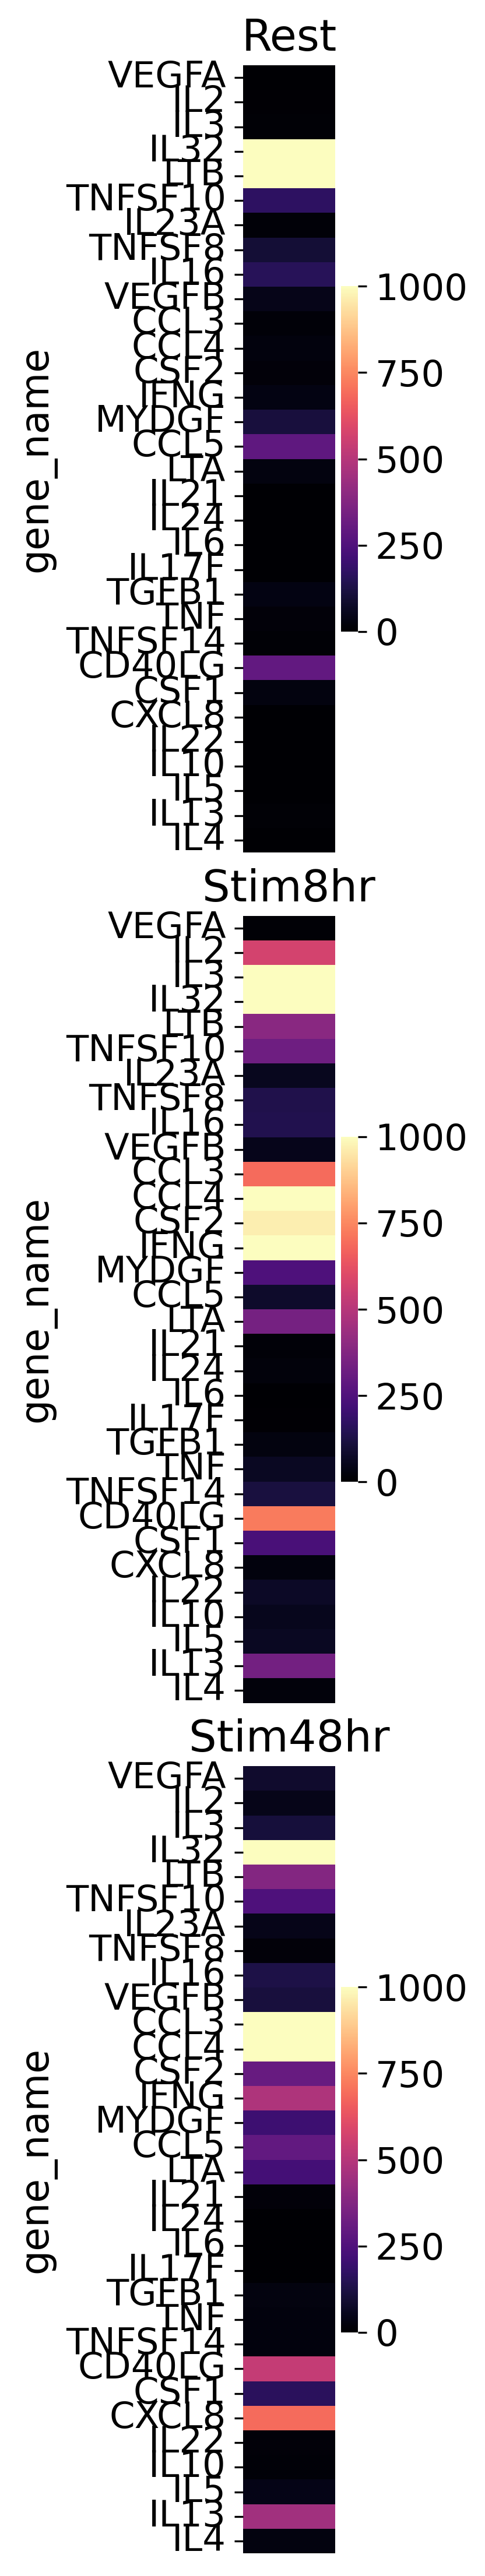

In [140]:
# Plot expression
rest_pl_df = filtered_df[filtered_df['culture_condition'] == 'Rest'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='baseMean'
).reindex(index=all_genes_order, columns=unique_regulators_order).mean(1)

stim8hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim8hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='baseMean'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0).mean(1)

stim48hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim48hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='baseMean'
).reindex(index=all_genes_order, columns=unique_regulators_order).mean(1)
# Create figure
plt.figure(figsize=(2, 15))

# Plot heatmaps for each condition
plt.subplot(3, 1, 1)
sns.heatmap(rest_pl_df.to_frame(), cmap='magma', vmax=1000, vmin=0, cbar=True, xticklabels=False, yticklabels=True)
plt.title('Rest')
plt.xlabel('')

plt.subplot(3, 1, 2)
sns.heatmap(stim8hr_pl_df.to_frame(), cmap='magma', vmax=1000, vmin=0, cbar=True, xticklabels=False, yticklabels=True)
plt.title('Stim8hr')
plt.xlabel('')

plt.subplot(3, 1, 3)
sns.heatmap(stim48hr_pl_df.to_frame(),  cmap='magma', vmax=1000, vmin=0, cbar=True, xticklabels=False, yticklabels=True)
plt.title('Stim48hr')
plt.xlabel('')

plt.tight_layout()

In [256]:
len(all_genes_order)

30

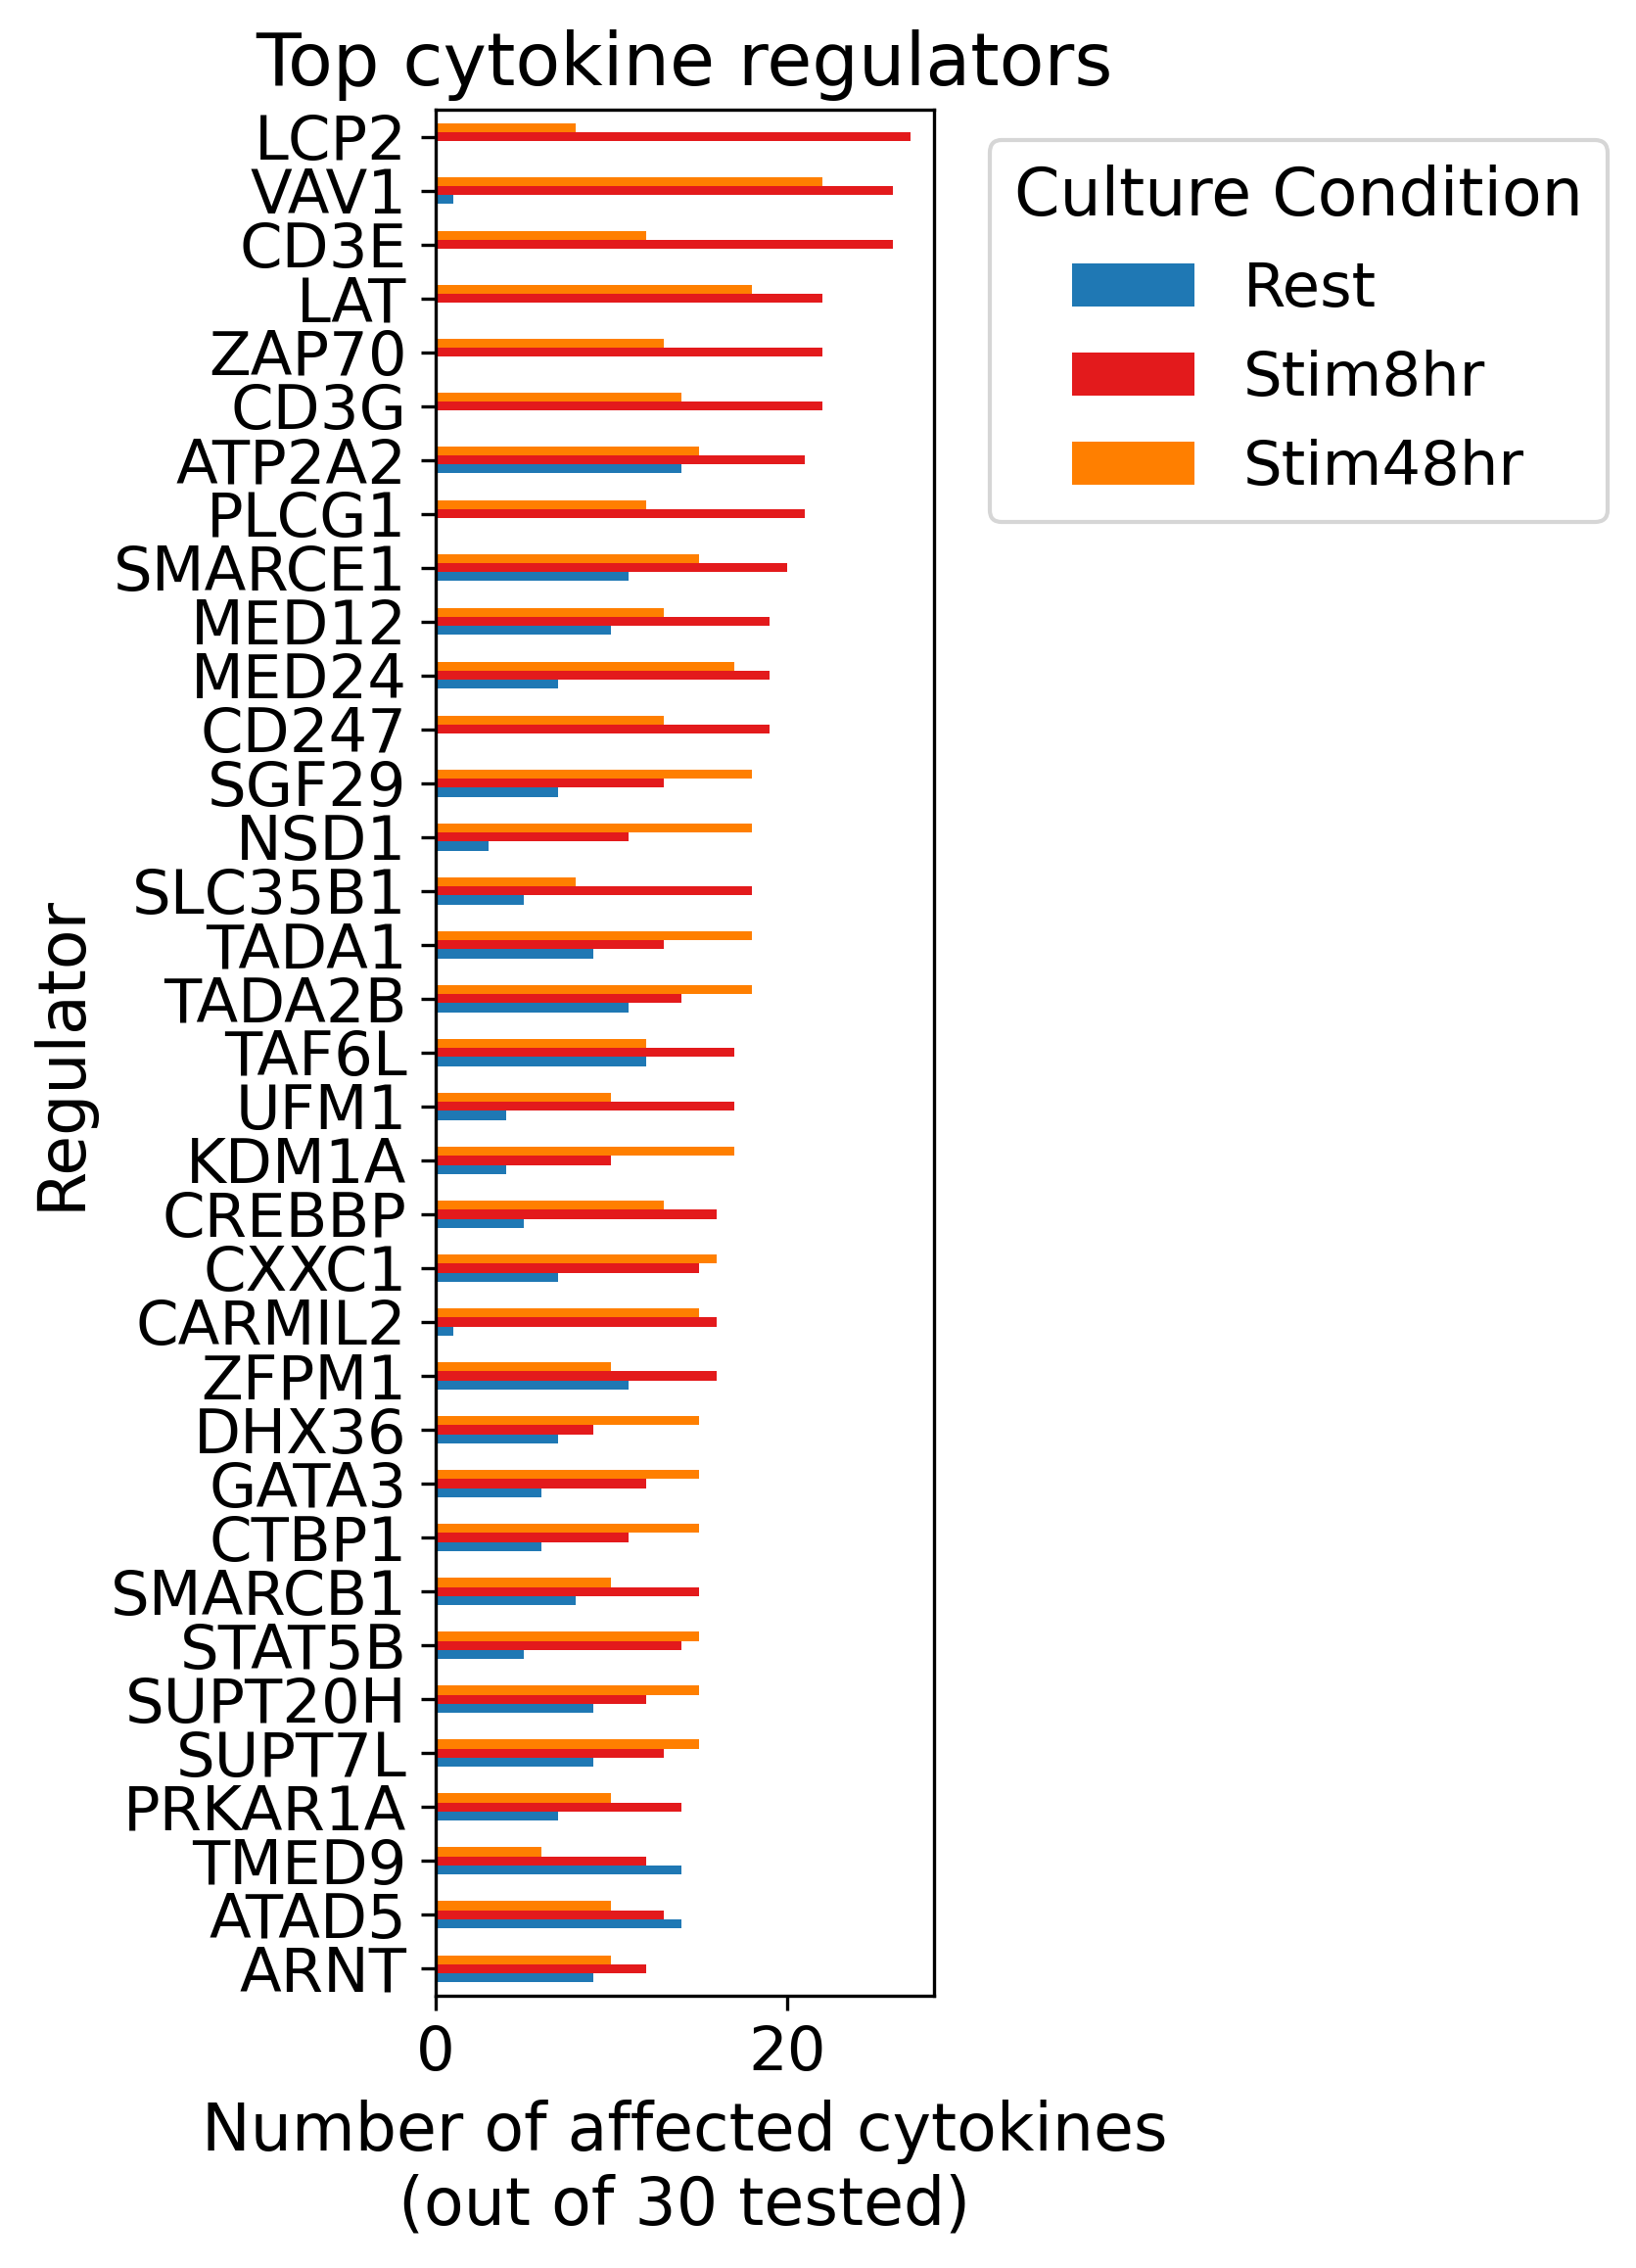

In [282]:
# Plot the number of significant findings for each unique regulator as a stacked bar plot
significant_counts = cytokines_de_df[cytokines_de_df.target_contrast_gene_name.isin(unique_regulators)].groupby(['target_contrast_gene_name', 'culture_condition'])['significant'].sum().unstack()
total_counts = significant_counts.sum(1)
total_counts = total_counts[total_counts > 30]
max_counts = significant_counts.loc[total_counts.index].max(1).sort_values()
significant_counts = significant_counts.loc[max_counts.index]

# Define color mapping for culture conditions
fig, ax = plt.subplots(figsize=(6, 8))
significant_counts.plot(kind='barh', stacked=False, color=[palettes['culture_condition'][col] for col in significant_counts.columns], ax=ax)
plt.ylabel('Regulator')
plt.xlabel('Number of affected cytokines\n(out of 30 tested)')
plt.title('Top cytokine regulators')
plt.legend(title='Culture Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('results/top_cytokine_regulators.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [233]:
n_top = 8

# Get top target conditions for each cytokine
top_target_conditions = []
cytokine_to_targets = {}
from tqdm import tqdm
for cytokine in tqdm(cytokines_de_df['gene_name'].unique()):
    # Get data for this cytokine
    cytokine_data = cytokines_de_df[cytokines_de_df['gene_name'] == cytokine]
    cytokine_data = cytokine_data[cytokine_data['significant']]
    
    # Get top 2 positive effects by zscore
    top_pos = cytokine_data.nlargest(n_top, 'zscore')['target_condition'].unique()
    
    # Get top 2 negative effects by zscore
    top_neg = cytokine_data.nsmallest(n_top, 'zscore')['target_condition'].unique()
    
    # Store in dictionary
    cytokine_to_targets[cytokine] = list(top_pos) + list(top_neg)
    
    # Add to overall list
    top_target_conditions.extend(top_pos)
    top_target_conditions.extend(top_neg)

# Remove duplicates while preserving order
top_target_conditions_ls = list(dict.fromkeys(top_target_conditions))
top_targets = [x.split('_')[0] for x in top_target_conditions_ls]
cytokine_to_targets = {k:[x.split('_')[0] for x in v] for k,v in cytokine_to_targets.items()}

100%|██████████| 30/30 [00:01<00:00, 21.01it/s]


In [234]:
# Get which target-cytokine trans effects are discovered in each condition
# First get the discovery condition matrix as before
discovery_condition = cytokines_de_df[cytokines_de_df['target_contrast_gene_name'].isin(top_targets)].pivot(index=['target_contrast_gene_name', 'gene_name'], columns='culture_condition', values='significant').fillna(False).reset_index()

# For each target, calculate what fraction of its total discoveries occur in each condition
discovery_counts_by_target = discovery_condition.groupby('target_contrast_gene_name')[['Rest', 'Stim8hr', 'Stim48hr']].sum()
discovery_fractions_by_target = discovery_counts_by_target.div(discovery_counts_by_target.sum(axis=1), axis=0).reset_index()

# For each cytokine, calculate what fraction of its regulators are discovered in each condition
discovery_counts_by_cytokine = discovery_condition.groupby('gene_name')[['Rest', 'Stim8hr', 'Stim48hr']].sum()
discovery_fractions_by_cytokine = discovery_counts_by_cytokine.div(discovery_counts_by_cytokine.sum(axis=1), axis=0).reset_index()

# Rename for clarity since we'll use both
discovery_fractions = discovery_fractions_by_target

# Filter data for top conditions and create pivot table
filtered_df = cytokines_de_df[cytokines_de_df['target_condition'].isin(top_target_conditions_ls)]
filtered_df['effect_size'] = filtered_df['zscore'].abs()

# For each target-gene pair, keep only the condition with strongest effect
filtered_df = filtered_df[filtered_df['significant']]
filtered_df = filtered_df.loc[filtered_df.groupby(['target_contrast_gene_name', 'gene_name'], observed=True)['effect_size'].idxmax()]
filtered_df.loc[~filtered_df['significant'], 'zscore'] = 0

# Create pivot table with strongest effect across conditions
pl_df = filtered_df.pivot(index='gene_name', columns=['target_contrast_gene_name'], values='zscore').fillna(0)
all_genes = pl_df.index
all_targets = [col.split('_')[0] for col in pl_df.columns]

# Create matched pivot table for each condition
filtered_df = cytokines_de_df[(cytokines_de_df['gene_name'].isin(all_genes)) & (cytokines_de_df['target_contrast_gene_name'].isin(all_targets))]
filtered_df.loc[~filtered_df['significant'], 'zscore'] = 0

# Create pivot tables with explicit index and columns to ensure same shape
rest_pl_df = filtered_df[filtered_df['culture_condition'] == 'Rest'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes, columns=all_targets).fillna(0)

stim8hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim8hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes, columns=all_targets).fillna(0)

stim48hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim48hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes, columns=all_targets).fillna(0)

# Verify shapes match
assert rest_pl_df.shape == stim8hr_pl_df.shape == stim48hr_pl_df.shape == pl_df.shape

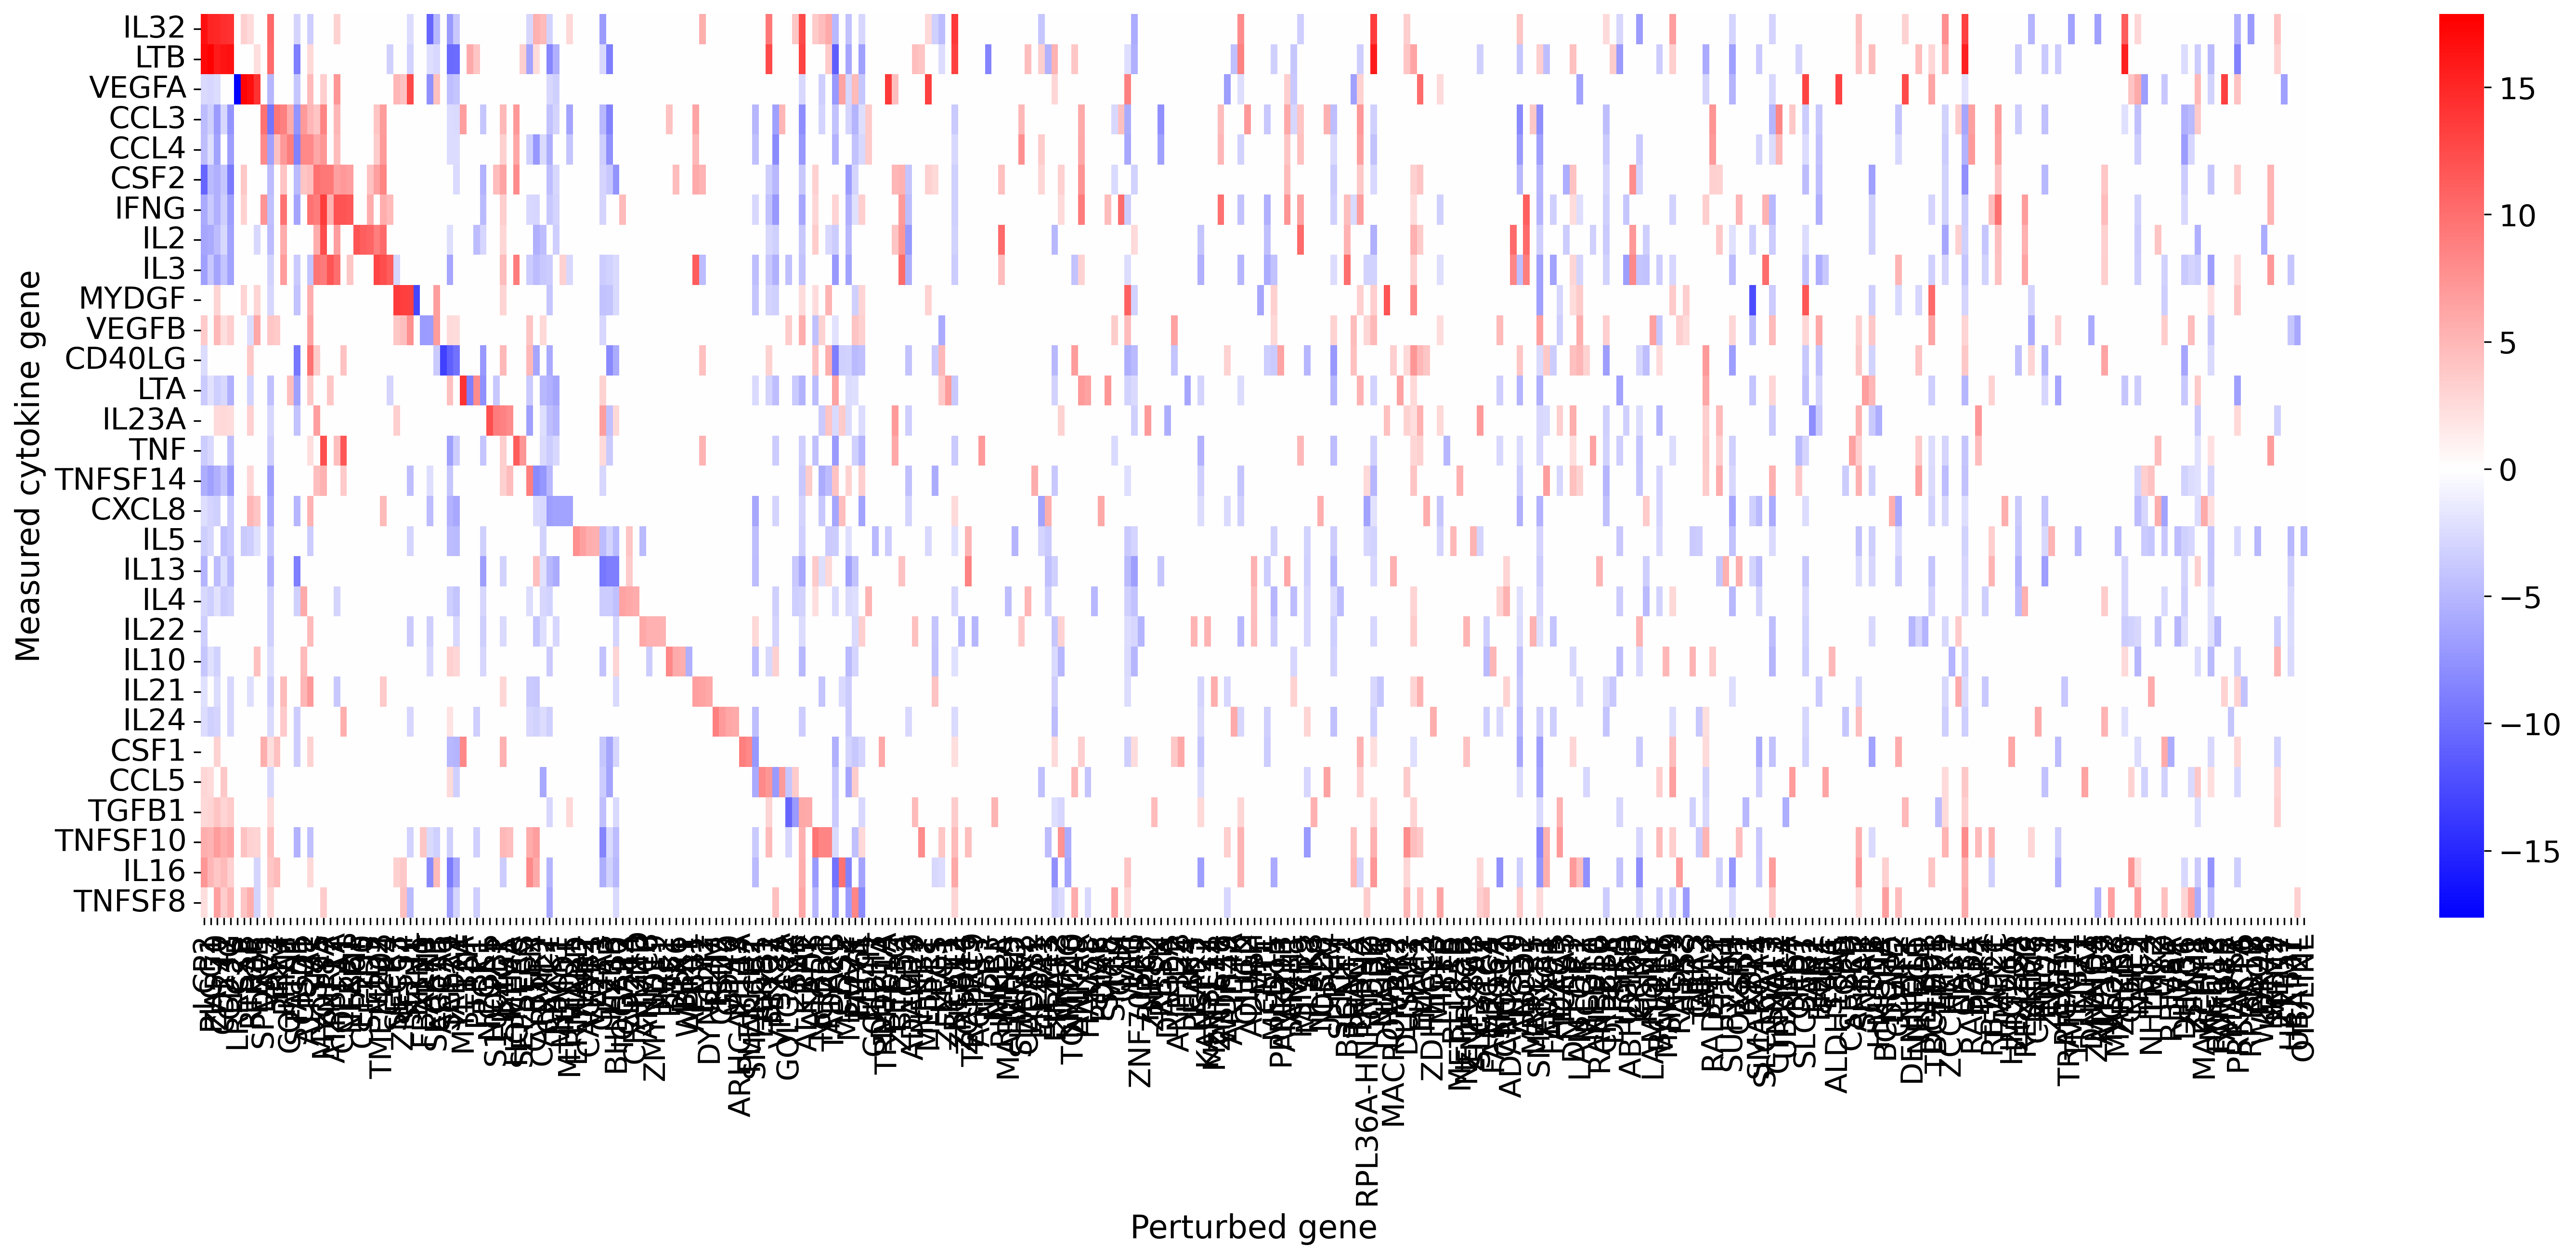

In [235]:

# Cluster rows (cytokines) by similarity
from scipy.cluster.hierarchy import linkage, leaves_list
row_linkage = linkage(pl_df, method='average')
row_order = leaves_list(row_linkage)
pl_df = pl_df.iloc[row_order]

# For each cytokine, find the top 6 conditions with strongest absolute effects
strongest_conditions = []
for cytokine in pl_df.index:
    # Get absolute values and sort to find top 6 conditions
    abs_effects = pl_df.loc[cytokine].abs()
    top_6_conds = abs_effects.nlargest(4).index.tolist()
    strongest_conditions.extend(top_6_conds)

ordered_cols = list(dict.fromkeys(strongest_conditions))
remaining_cols = set(pl_df.columns) - set(ordered_cols)
ordered_cols.extend(remaining_cols)

# Reorder the dataframe columns and rename to just target names
pl_df = pl_df[ordered_cols]
rest_pl_df = rest_pl_df.loc[pl_df.index, ordered_cols]
stim8hr_pl_df = stim8hr_pl_df.loc[pl_df.index, ordered_cols]
stim48hr_pl_df = stim48hr_pl_df.loc[pl_df.index, ordered_cols]

assert pl_df.columns.is_unique

discovery_frac_pl_df = discovery_fractions.dropna().set_index('target_contrast_gene_name').loc[pl_df.columns]
# Bottom subplot - heatmap
plt.figure(figsize=(20,9))
sns.heatmap(pl_df, center=0, cmap='bwr', cbar_kws={'location': 'right'}, xticklabels=True)
plt.xlabel('Perturbed gene')
plt.ylabel('Measured cytokine gene')
plt.tight_layout()


In [236]:
filtered_df = cytokines_de_df[(cytokines_de_df['gene_name'].isin(all_genes)) & (cytokines_de_df['target_contrast_gene_name'].isin(all_targets))]
# filtered_df.loc[~filtered_df['significant'], 'zscore'] = 0

# Filter targets for each cytokine
filtered_rows = []
for gene_name in filtered_df['gene'].unique():
    if gene_name in cytokine_to_targets:
        valid_targets = cytokine_to_targets[gene_name]
        gene_df = filtered_df[
            (filtered_df['gene'] == gene_name) & 
            (filtered_df['target_contrast_gene_name'].isin(valid_targets))
        ]
        filtered_rows.append(gene_df)

filtered_df = pd.concat(filtered_rows, ignore_index=True)

# Compute mean zscore across conditions for each cytokine-target pair
mean_zscores = filtered_df.groupby(['gene', 'target_contrast_gene_name'])['zscore'].mean().reset_index()

plot_df_pos = pd.merge(mean_zscores[mean_zscores['zscore'] > 0][['gene', 'target_contrast_gene_name']], filtered_df, how='left')
plot_df_neg = pd.merge(mean_zscores[mean_zscores['zscore'] < 0][['gene', 'target_contrast_gene_name']], filtered_df, how='left')

In [297]:
def create_cytokine_regulation_plot(plot_df, title, ax=None, right_label=False, gene_label_fontsize=14, offset_scale = 0.5, row_order=None):
    # If no ax is provided, create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 20))
    
    # Create a mapping from gene-target pair to a numeric y-position with spacing between cytokines
    gene_target_pairs = []
    y_positions = []
    y_labels = []
    y_pos = 0
    prev_gene = None

    # Use row_order to sort the genes
    sorted_plot_df = plot_df.copy()
    sorted_plot_df['gene_order'] = sorted_plot_df['gene'].map({gene: idx for idx, gene in enumerate(row_order)})
    sorted_plot_df = sorted_plot_df.sort_values(['gene_order', 'gene', 'target_contrast_gene_name'])

    for idx, row in sorted_plot_df.iterrows():
        gene = row['gene']
        target = row['target_contrast_gene_name']
        pair = f"{gene} - {target}"
        
        # Add extra spacing between different cytokines
        if prev_gene is not None and gene != prev_gene:
            y_pos += 0.5  # Add spacing between cytokines
        
        if pair not in gene_target_pairs:
            gene_target_pairs.append(pair)
            y_positions.append(y_pos)
            y_labels.append(target)  # Only show target name on y-axis
            y_pos += 1
        
        prev_gene = gene

    # Map the pairs to their positions - optimized with vectorized operation
    pair_to_pos = dict(zip(gene_target_pairs, y_positions))
    sorted_plot_df['gene_target_pair'] = sorted_plot_df['gene'].astype(str) + ' - ' + sorted_plot_df['target_contrast_gene_name'].astype(str)
    sorted_plot_df['y_position'] = sorted_plot_df['gene_target_pair'].map(pair_to_pos)

    # Create scatter plot using numeric y positions, masking out zscore=0
    plot_df_nonzero = sorted_plot_df[sorted_plot_df['zscore'] != 0]
    
    # Separate significant and non-significant points
    significant_points = plot_df_nonzero[plot_df_nonzero['significant']]
    non_significant_points = plot_df_nonzero[~plot_df_nonzero['significant']]
    
    # Add background color for each cytokine group
    unique_genes = sorted_plot_df['gene'].unique()
    for i, gene in enumerate(unique_genes):
        gene_pairs = [p for p in gene_target_pairs if p.startswith(gene + ' - ')]
        gene_y_positions = [pair_to_pos[p] for p in gene_pairs]
        
        # Alternate background colors
        bg_color = 'white' if i % 2 == 0 else 'lightgray'
        
        ax.axhspan(min(gene_y_positions)-0.5, max(gene_y_positions)+0.5, 
                   facecolor=bg_color, alpha=0.3, zorder=-1)

    # Plot non-significant points without outline
    sns.scatterplot(data=non_significant_points,
                    y='y_position', 
                    x='zscore',
                    hue='culture_condition', 
                    palette=palettes['culture_condition'],
                    ax=ax,
                    s=80,
                    alpha=0.6,
                    edgecolor='none'
                    )
    
    # Plot significant points with black outline
    sns.scatterplot(data=significant_points,
                    y='y_position', 
                    x='zscore',
                    hue='culture_condition', 
                    palette=palettes['culture_condition'],
                    ax=ax,
                    s=80,
                    edgecolor='black',
                    linewidth=1
                    )

    # Set y-axis ticks and labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel('')

    # Add cytokine labels to the left of the y-axis
    # Find the position of each cytokine group
    prev_gene = None
    gene_positions = []
    gene_names = []

    for pair, pos in zip(gene_target_pairs, y_positions):
        gene = pair.split(' - ')[0]
        if gene != prev_gene:
            gene_positions.append(pos)
            gene_names.append(gene)
            prev_gene = gene

    # Calculate the middle position for each cytokine group
    gene_label_positions = []
    for i, gene in enumerate(gene_names):
        # Find all positions for this gene
        gene_pairs = [p for p in gene_target_pairs if p.startswith(gene + ' - ')]
        gene_y_positions = [pair_to_pos[p] for p in gene_pairs]
        # Calculate middle position
        mid_pos = (min(gene_y_positions) + max(gene_y_positions)) / 2
        gene_label_positions.append(mid_pos)

    # Add text labels for cytokines to the left
    xlim = ax.get_xlim()
    x_offset = xlim[0] - (xlim[1] - xlim[0]) * offset_scale  # Increased white space on the left
    if right_label:
        ax.yaxis.tick_right()  # Move y-axis ticks to the right side
        ax.yaxis.set_label_position('right')  # Move y-axis label to the right
        
    else:
        for gene, pos in zip(gene_names, gene_label_positions):
            ax.text(x_offset, pos, gene, 
                    fontsize=gene_label_fontsize, fontweight='bold', 
                    ha='center', va='center')

    ax.axvline(x=0, color='grey')
    ax.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.5)
    sns.despine()

    # Adjust plot margins to make room for cytokine labels
    plt.subplots_adjust(left=0.2)  # Increased left margin
    ax.set_xlabel('Z-score')
    ax.set_title(title, fontsize=12, pad=10)

    plt.tight_layout()

# # Create plots for positive and negative regulators
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 18), gridspec_kw={'width_ratios': [1,1], 'wspace': 0.6})  # Increased figure width and added whitespace between plots
# create_cytokine_regulation_plot(plot_df_pos, 'Negative Regulators of Cytokines', ax=ax2)
# # plt.subplots_adjust(left=0.4)  # Increased margin
# create_cytokine_regulation_plot(plot_df_neg, 'Positive Regulators of Cytokines', ax=ax1, right_label=True)
# # plt.subplots_adjust(right=0.4)  # Increased margin
# plt.tight_layout()

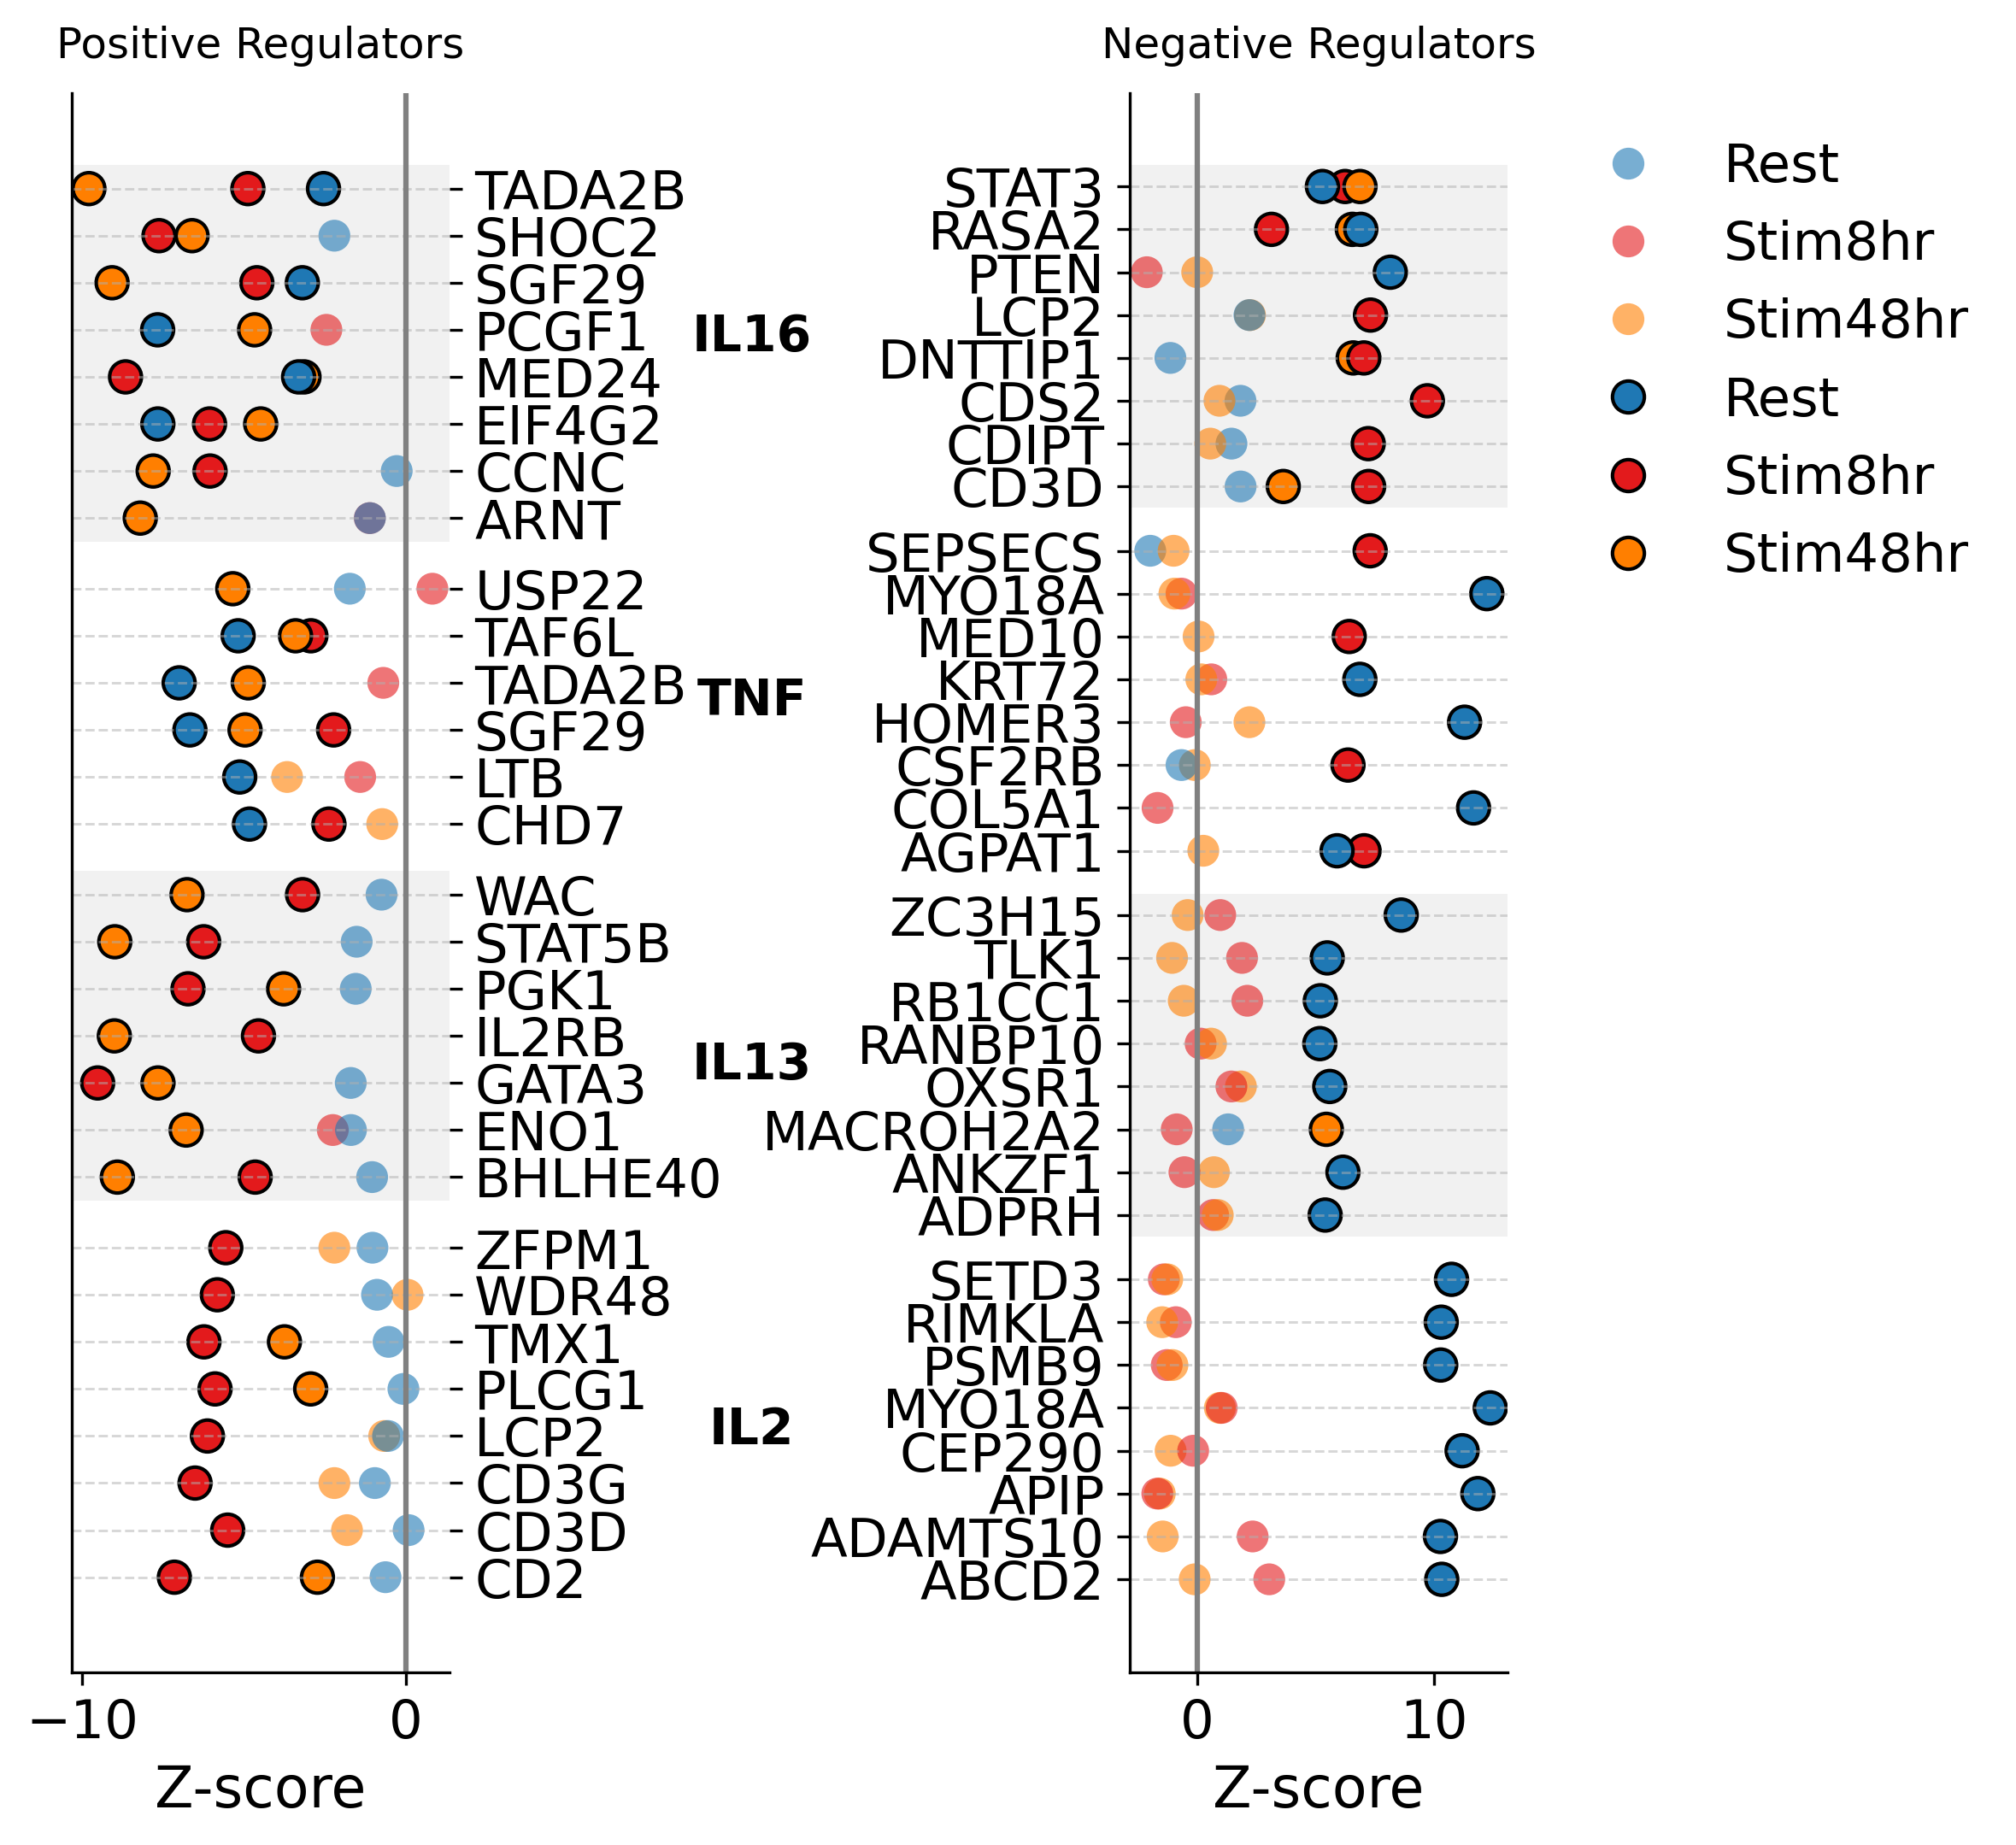

In [298]:
pl_cytokines = ['IL2', 'IL13', 'TNF', 'IL16']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), gridspec_kw={'wspace': 1.8})  # Increased figure width and added whitespace between plots
create_cytokine_regulation_plot(plot_df_neg[plot_df_neg['gene_name'].isin(pl_cytokines)].sort_values('gene_name'), 'Positive Regulators', ax=ax1, right_label=True, row_order=pl_cytokines)
create_cytokine_regulation_plot(plot_df_pos[plot_df_pos['gene_name'].isin(pl_cytokines)].sort_values('gene_name'), 'Negative Regulators', ax=ax2, offset_scale = 1.0, row_order=pl_cytokines)

ax1.legend([], frameon=False)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.savefig('results/cytokine_regulators_example.pdf', bbox_inches='tight', dpi=300)


<Axes: xlabel='zscore', ylabel='culture_condition'>

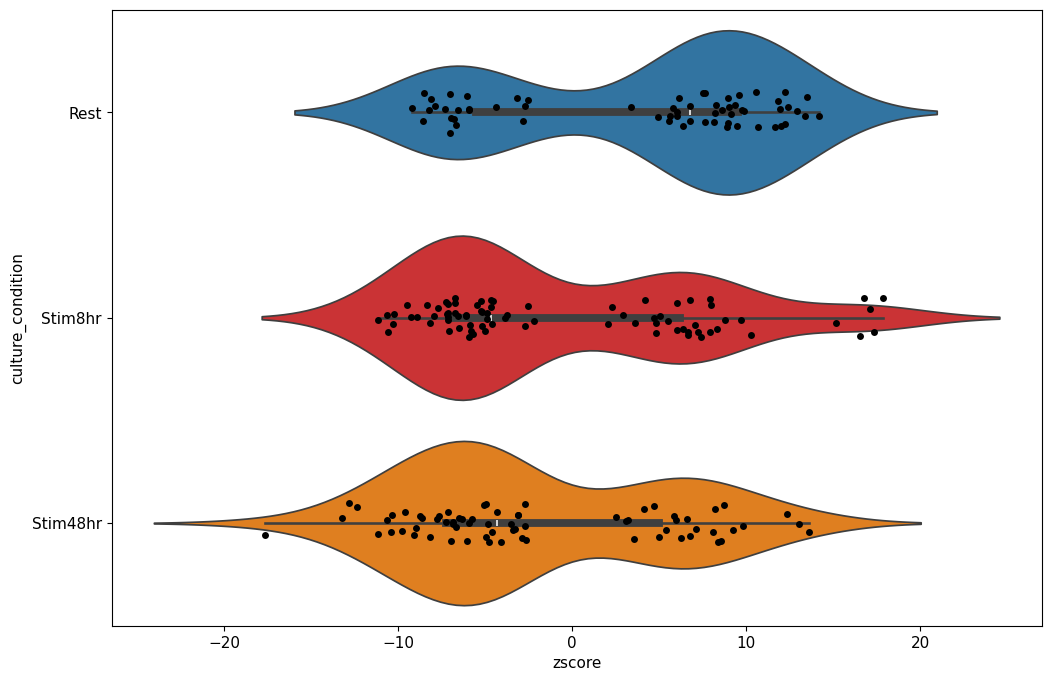

In [95]:

sns.violinplot(data=plot_df, x='zscore', y='culture_condition',hue='culture_condition', palette=palettes['culture_condition'])
sns.stripplot(data=plot_df, x='zscore', y='culture_condition', color='black')

# sns.violinplot(data=plot_df_pos, x='zscore', y='culture_condition',hue='culture_condition', palette=palettes['culture_condition'])
# sns.stripplot(data=plot_df_pos, x='zscore', y='culture_condition',hue='culture_condition', palette=palettes['culture_condition'])

In [ ]:
# cytokines_de_df = get_DE_results_long(adata_de, genes=['IL10'])
# cytokines_de_df.sort_values('zscore')

index  gene    log_fc    zscore   adj_p_value  \
22592   ENSG00000166272_Stim8hr  IL10 -5.198875 -5.493209  4.881974e-04   
10495   ENSG00000121766_Stim8hr  IL10 -4.694306 -5.249278  4.341173e-04   
14496   ENSG00000136634_Stim8hr  IL10 -6.854601 -5.195664  2.523366e-03   
23635   ENSG00000168610_Stim8hr  IL10 -5.173587 -5.126577  1.683641e-05   
12806   ENSG00000131323_Stim8hr  IL10 -3.874074 -5.069633  3.921264e-05   
...                         ...   ...       ...       ...           ...   
13512   ENSG00000133895_Stim8hr  IL10  4.415139  5.218855  1.989982e-05   
28731  ENSG00000185630_Stim48hr  IL10  4.513667  5.604773  2.646645e-04   
5081   ENSG00000101213_Stim48hr  IL10  4.757431  5.943126  1.772622e-05   
11560  ENSG00000125870_Stim48hr  IL10  6.402714  7.940559           NaN   
1941   ENSG00000064933_Stim48hr  IL10  7.050557  8.215061  8.971370e-13   

       significant gene_name culture_condition  target_contrast  \
22592         True      IL10           Stim8hr  ENSG00000166272   
10495         True      IL10           Stim8hr  ENSG00000121766   
14496         True      IL10           Stim8hr  ENSG00000136634   
23635         True      IL10           Stim8hr  ENSG00000168610   
12806         True      IL10           Stim8hr  ENSG00000131323   
...            ...       ...               ...              ...   
13512         True      IL10           Stim8hr  ENSG00000133895   
28731         True      IL10          Stim48hr  ENSG00000185630   
5081          True      IL10          Stim48hr  ENSG00000101213   
11560        False      IL10          Stim48hr  ENSG00000125870   
1941          True      IL10          Stim48hr  ENSG00000064933   

      target_contrast_gene_name  
22592                     WBP1L  
10495                   ZCCHC17  
14496                      IL10  
23635                     STAT3  
12806                     TRAF3  
...                         ...  
13512                      MEN1  
28731                      PBX1  
5081                       PTK6  
11560                    SNRPB2  
1941                       PMS1  

[33986 rows x 10 columns]

## Receptors

In [166]:
immune_genes_df[immune_genes_df.Category == 'Receptor']

gene_name  Category
38       AHR  Receptor
39     ANXA1  Receptor
40      BTLA  Receptor
41      CCR4  Receptor
42      CCR6  Receptor
43      CCR7  Receptor
44      CCR8  Receptor
45     CD274  Receptor
46      CD38  Receptor
47       CD4  Receptor
48       CD5  Receptor
49      CD69  Receptor
50      CD8A  Receptor
51     CTLA4  Receptor
52     CXCR3  Receptor
53     CXCR4  Receptor
54     CXCR5  Receptor
55     FGFR1  Receptor
56      ICOS  Receptor
57    IFNGR1  Receptor
58    IFNGR2  Receptor
59   IL12RB1  Receptor
60    IL17RA  Receptor
61    IL17RB  Receptor
62     IL1R1  Receptor
63     IL21R  Receptor
64     IL2RA  Receptor
65     IL2RG  Receptor
66      IL4R  Receptor
67      IL6R  Receptor
68      IL7R  Receptor
69     ITGA4  Receptor
70      LAG3  Receptor
71    NOTCH1  Receptor
72    NOTCH2  Receptor
73     PDCD1  Receptor
74    SLAMF7  Receptor
75    TGFBR2  Receptor
76     TIGIT  Receptor
77  TNFRSF14  Receptor
78  TNFRSF18  Receptor
79  TNFRSF1B  Receptor
80  TNFRSF25  Receptor
81   TNFRSF4  Receptor
82   TNFRSF9  Receptor
83      DPP4  Receptor

In [167]:
immune_genes_df = pd.read_csv('../../metadata/immune_effector_genes.csv')
receptors = immune_genes_df[immune_genes_df.Category == 'Receptor']['gene_name'].tolist()
len(receptors)

46

In [168]:
receptors_de_df = get_DE_results_long(adata_de, genes=receptors, effect_estimates=['zscore', 'log_fc', 'baseMean'])
receptors_de_df['target_condition'] = receptors_de_df['target_contrast_gene_name'].astype(str) + '_' +  receptors_de_df['culture_condition'].astype(str)
# Exclude on target
receptors_de_df = receptors_de_df[receptors_de_df['gene_name'] != receptors_de_df['target_contrast_gene_name']]


1349


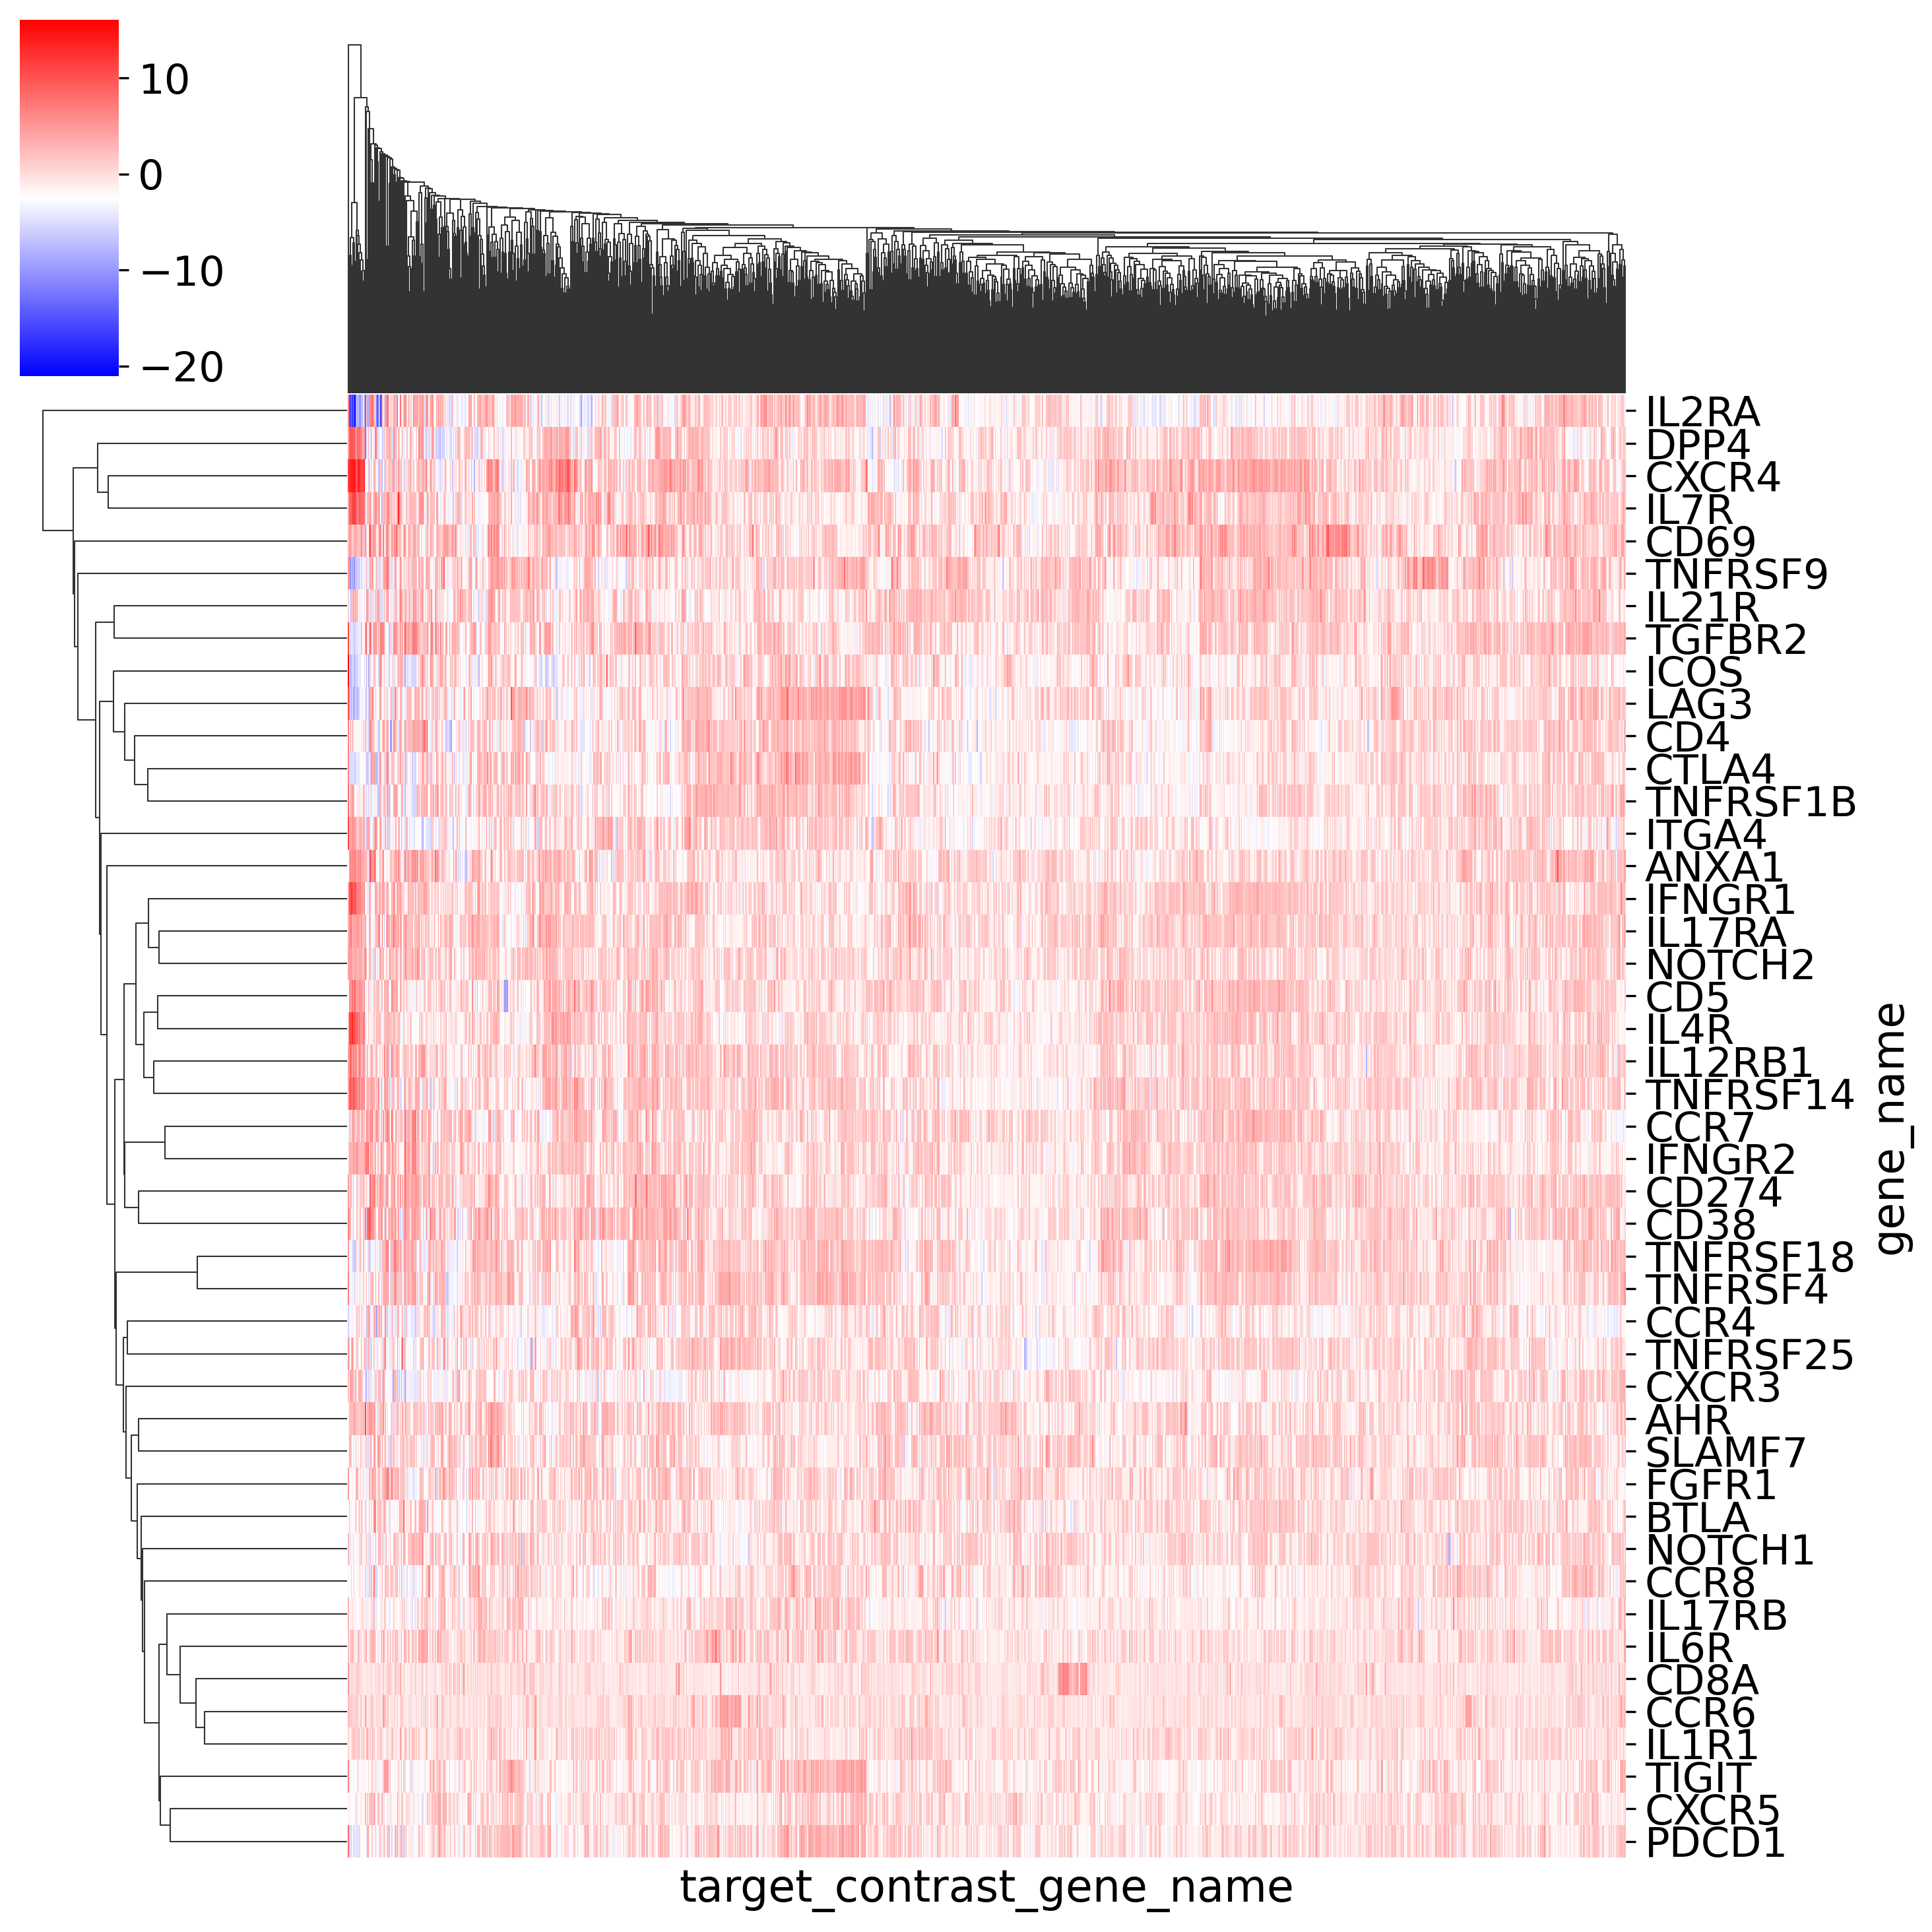

In [169]:
# Get signif regulators in at least one condition
unique_regulators = receptors_de_df[receptors_de_df['adj_p_value'] < 0.01]['target_contrast_gene_name'].unique()

print(len(unique_regulators))

filtered_df = receptors_de_df[receptors_de_df['target_contrast_gene_name'].isin(unique_regulators)]
filtered_df['effect_size'] = filtered_df['zscore'].abs()
all_genes = filtered_df['gene_name'].unique()

# Create pivot table with strongest effect across conditions (to cluster regulators for viz)
top_filtered_df = filtered_df.loc[filtered_df.groupby(['target_contrast_gene_name', 'gene_name'], observed=True)['effect_size'].idxmax()]
# top_filtered_df.loc[~top_filtered_df['significant'], 'zscore'] = 0
pl_df = top_filtered_df.pivot(index='gene_name', columns=['target_contrast_gene_name'], values='zscore').fillna(0)

# Get clustered regulators order without plotting
g = sns.clustermap(pl_df, xticklabels=False, yticklabels=True, cmap='bwr')
unique_regulators_order = pl_df.columns[g.dendrogram_col.reordered_ind].tolist()
all_genes_order = pl_df.index[g.dendrogram_row.reordered_ind].tolist()
# plt.close()
assert unique_regulators.isin(unique_regulators_order).all()
assert pd.Series(all_genes).isin(all_genes_order).all()

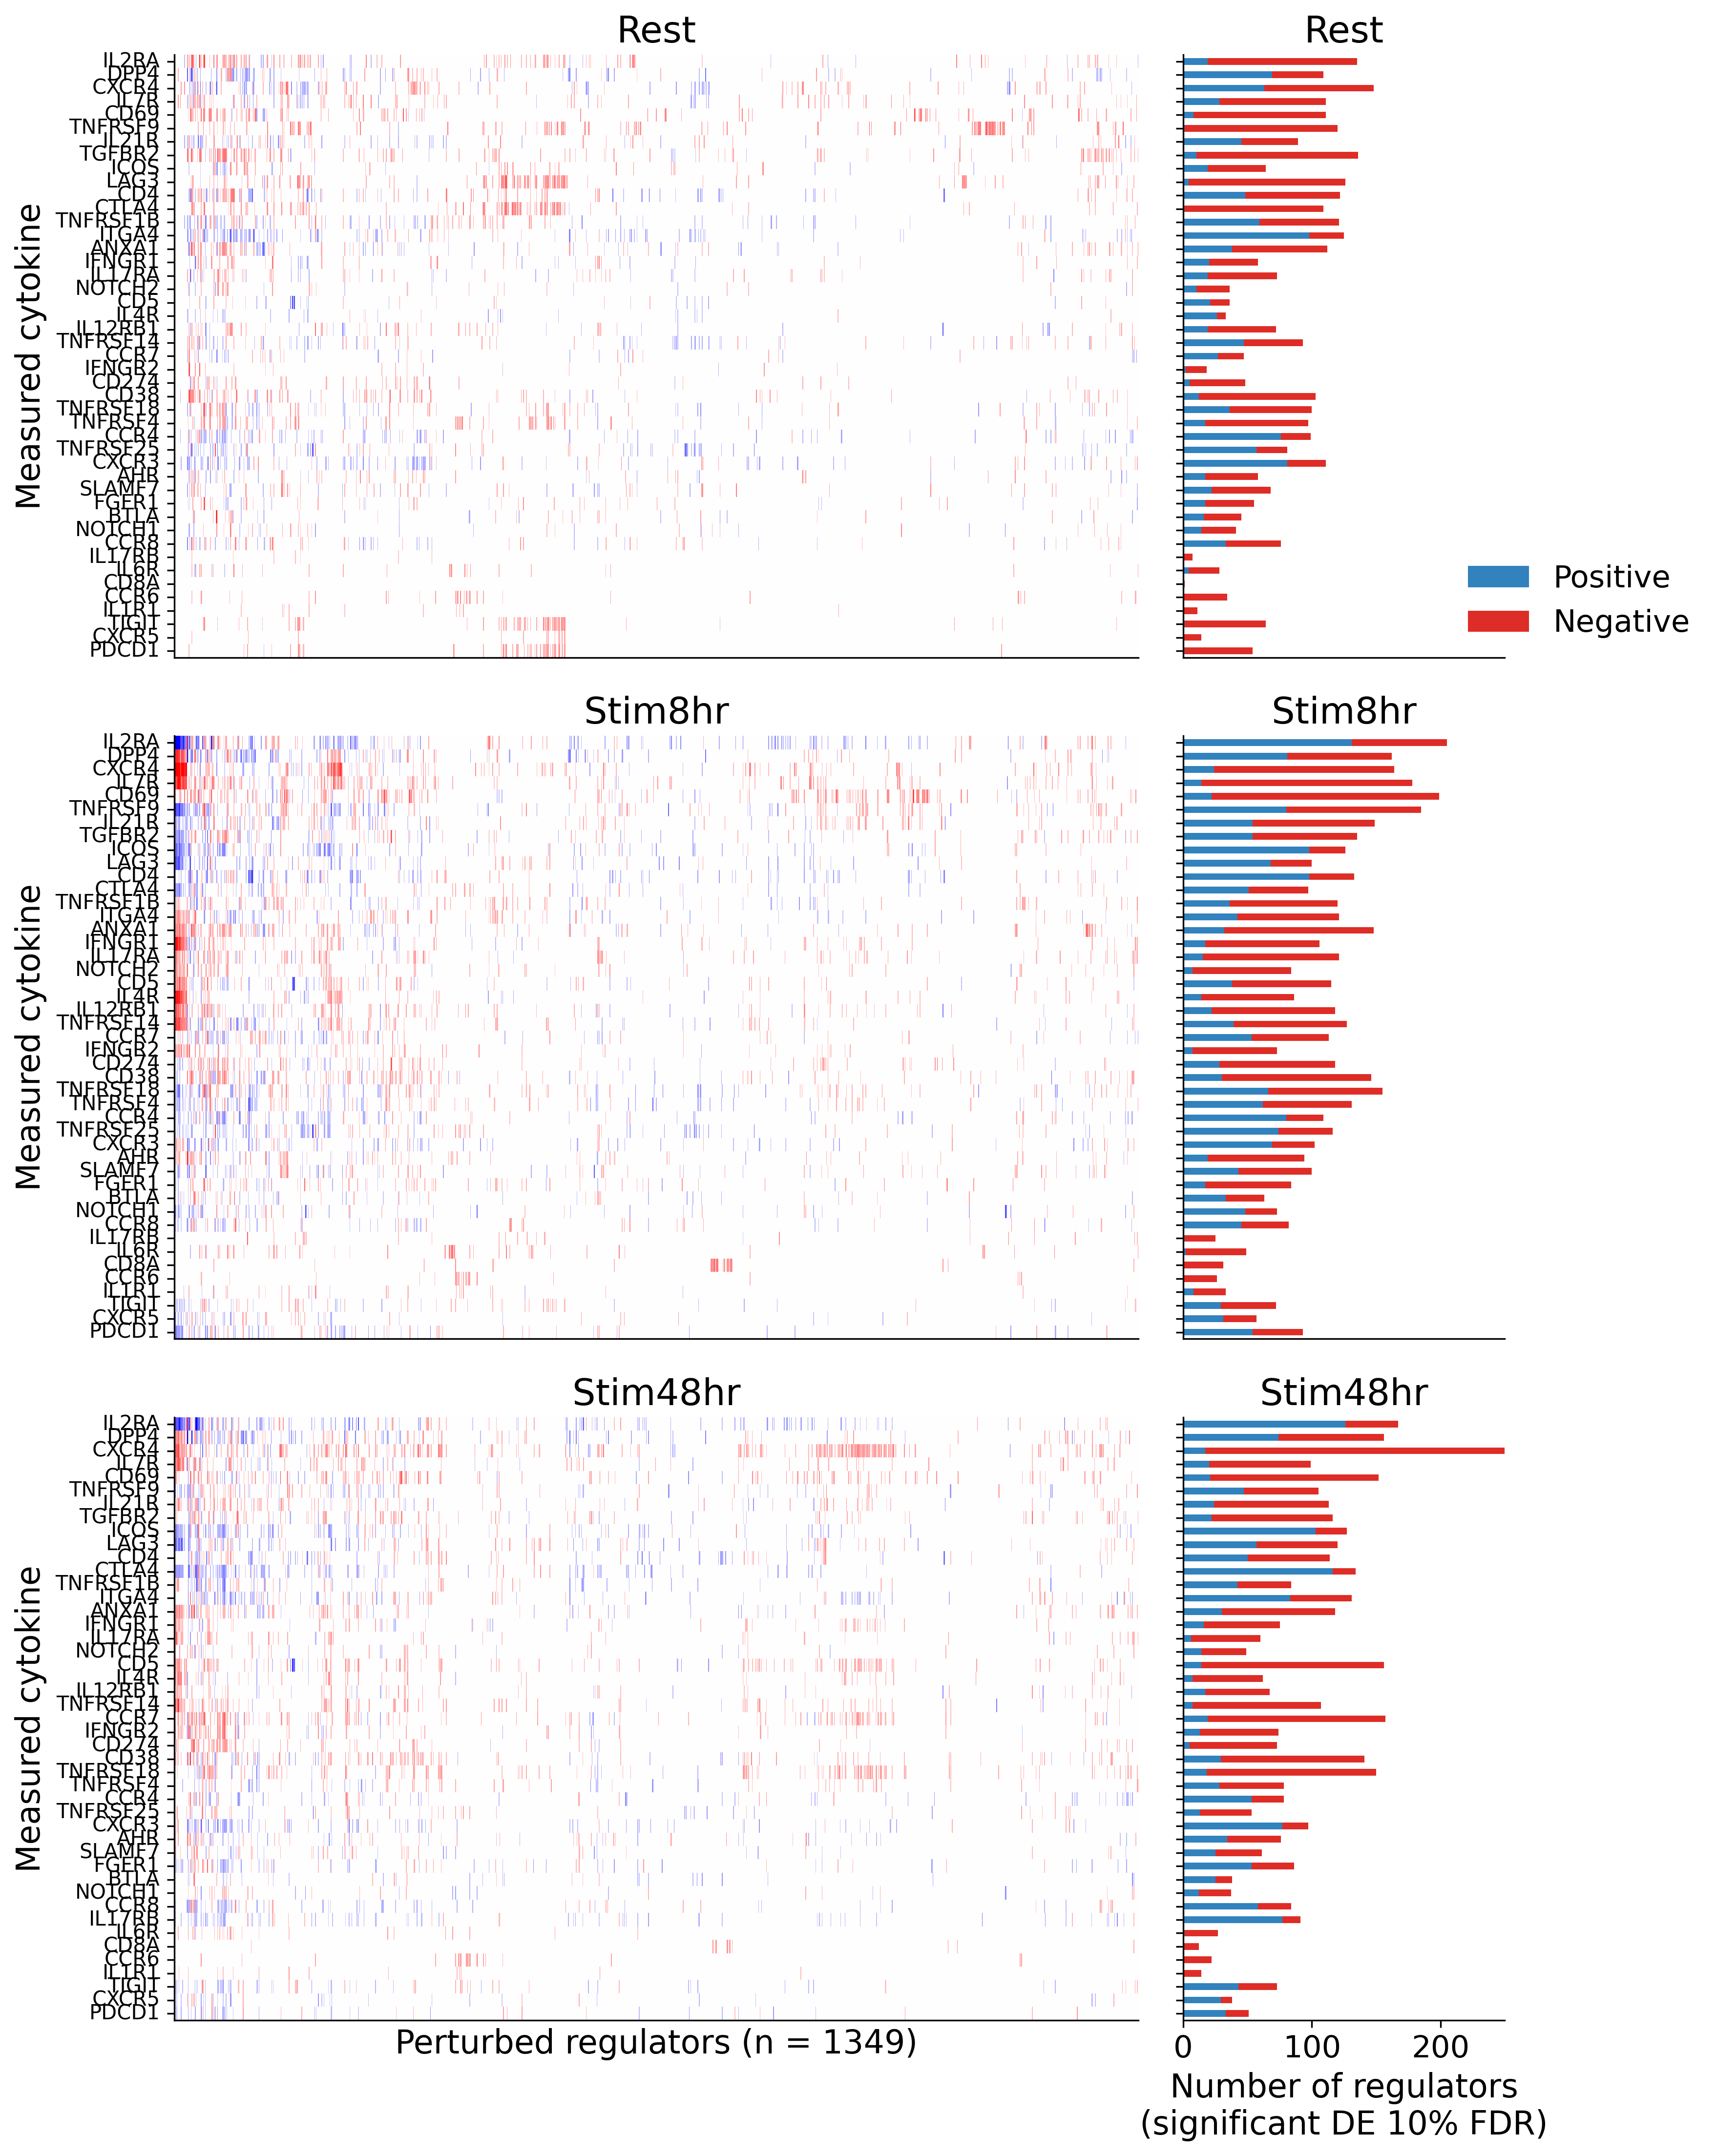

In [170]:
# Show only significant effects
filtered_df.loc[~filtered_df['significant'], 'zscore'] = 0

# Create pivot tables with explicit index and columns to ensure same shape
rest_pl_df = filtered_df[filtered_df['culture_condition'] == 'Rest'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0)

stim8hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim8hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0)

stim48hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim48hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='zscore'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0)

# Get counts of positive and negative regulators for each cytokine
def get_regulator_counts(df, condition):
    # Filter for condition and get direction of regulation
    # Count positive and negative regulators directly from wide matrix
    reg_counts = pd.DataFrame(index=df.index)
    reg_counts['Positive'] = (df < 0).sum(axis=1)  # Positive regulators have negative zscores
    reg_counts['Negative'] = (df > 0).sum(axis=1)  # Negative regulators have positive zscores
    
    # Ensure index matches expected order
    reg_counts = reg_counts.reindex(all_genes_order, fill_value=0)
    return reg_counts

# Get counts for each condition
reg_counts_rest = get_regulator_counts(rest_pl_df, 'Rest')
reg_counts_8hr = get_regulator_counts(stim8hr_pl_df, 'Stim8hr') 
reg_counts_48hr = get_regulator_counts(stim48hr_pl_df, 'Stim48hr')

# Create figure with 3 rows and 2 columns
y_labelsize = 10
fig = plt.figure(figsize=(12,15))
gs = fig.add_gridspec(3, 2, width_ratios=[3, 1])

# Define colors for consistent mapping
color_dict = {'Positive': '#3182bd', 'Negative': '#de2d26'}

# Rest condition heatmap
ax1 = fig.add_subplot(gs[0,0])
sns.heatmap(rest_pl_df, center=0, cmap='bwr', vmax=12, vmin=-12, cbar=False, xticklabels=False, yticklabels=True, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Measured cytokine')
ax1.set_title('Rest')
ax1.tick_params(axis='y', labelsize=y_labelsize)  # Reduce y-tick label size

# Rest condition barplot
ax2 = fig.add_subplot(gs[0,1])
reg_counts_rest.iloc[::-1].reindex(columns=['Positive', 'Negative']).plot(
    kind='barh', stacked=True, ax=ax2, color=[color_dict['Positive'], color_dict['Negative']])
ax2.set_ylabel('')  # Hide y-label since we removed ticks
ax2.set_xlabel('')  # Hide x-label since it's only shown on bottom
ax2.set_title('Rest')
ax2.set_xlim(0, 250)
ax2.xaxis.set_visible(False)  # Hide x-axis
ax2.set_yticklabels([])  # Remove y-tick labels
# Add legend only to top plot
ax2.legend(labels={"Positive":'Positive regulator', "Negative":'Negative regulator'}, bbox_to_anchor=(0.8, 0.2), frameon=False)

# Stim8hr condition heatmap
ax3 = fig.add_subplot(gs[1,0])
sns.heatmap(stim8hr_pl_df, center=0, cmap='bwr', vmax=12, vmin=-12, cbar=False, xticklabels=False, yticklabels=True, ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('Measured cytokine')
ax3.set_title('Stim8hr')
ax3.tick_params(axis='y', labelsize=y_labelsize)  # Reduce y-tick label size

# Stim8hr condition barplot
ax4 = fig.add_subplot(gs[1,1])
reg_counts_8hr.iloc[::-1].reindex(columns=['Positive', 'Negative']).plot(
    kind='barh', stacked=True, ax=ax4, color=[color_dict['Positive'], color_dict['Negative']])
ax4.set_ylabel('')  # Hide y-label since we removed ticks
ax4.set_xlabel('')  # Hide x-label since it's only shown on bottom
ax4.set_title('Stim8hr')
ax4.set_xlim(0, 250)
ax4.xaxis.set_visible(False)  # Hide x-axis
ax4.set_yticklabels([])  # Remove y-tick labels
ax4.get_legend().remove()  # Remove legend

# Stim48hr condition heatmap
ax5 = fig.add_subplot(gs[2,0])
sns.heatmap(stim48hr_pl_df, center=0, cmap='bwr', vmax=12, vmin=-12, cbar=False, xticklabels=False, yticklabels=True, ax=ax5)
ax5.set_xlabel(f'Perturbed regulators (n = {stim48hr_pl_df.shape[1]})')
ax5.set_ylabel('Measured cytokine')
ax5.set_title('Stim48hr')
ax5.tick_params(axis='y', labelsize=y_labelsize)  # Reduce y-tick label size

# Stim48hr condition barplot
ax6 = fig.add_subplot(gs[2,1])
reg_counts_48hr.iloc[::-1].reindex(columns=['Positive', 'Negative']).plot(
    kind='barh', stacked=True, ax=ax6, color=[color_dict['Positive'], color_dict['Negative']])
ax6.set_ylabel('')  # Hide y-label since we removed ticks
ax6.set_xlabel('Number of regulators\n(significant DE 10% FDR)')  # Show x-label only on bottom plot
ax6.set_title('Stim48hr')
ax6.set_xlim(0, 250)
ax6.set_yticklabels([])  # Remove y-tick labels
ax6.get_legend().remove()  # Remove legend

# # Create colorbar
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# norm = plt.Normalize(vmin=-12, vmax=12)
# sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
# plt.colorbar(sm, cax=cbar_ax)
# cbar_ax.set_title('Z-score')

# Adjust layout
sns.despine()
plt.tight_layout()
# Save figure as PDF
plt.savefig('receptors_regulators_overview.pdf', bbox_inches='tight', dpi=300)


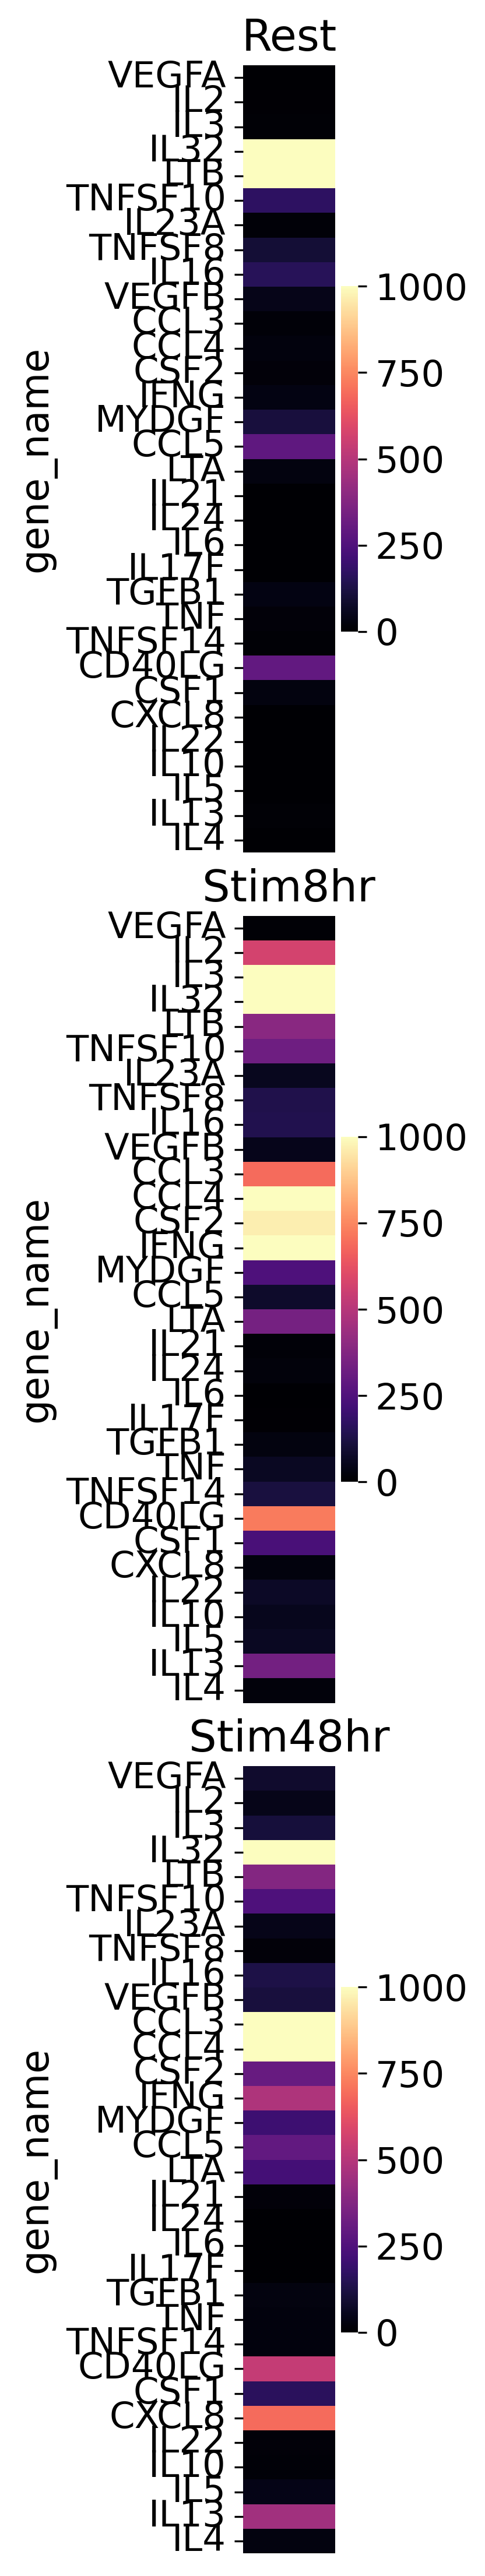

In [ ]:
# Plot expression
rest_pl_df = filtered_df[filtered_df['culture_condition'] == 'Rest'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='baseMean'
).reindex(index=all_genes_order, columns=unique_regulators_order).mean(1)

stim8hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim8hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='baseMean'
).reindex(index=all_genes_order, columns=unique_regulators_order).fillna(0).mean(1)

stim48hr_pl_df = filtered_df[filtered_df['culture_condition'] == 'Stim48hr'].pivot(
    index='gene_name', columns=['target_contrast_gene_name'], values='baseMean'
).reindex(index=all_genes_order, columns=unique_regulators_order).mean(1)
# Create figure
plt.figure(figsize=(2, 15))

# Plot heatmaps for each condition
plt.subplot(3, 1, 1)
sns.heatmap(rest_pl_df.to_frame(), cmap='magma', vmax=1000, vmin=0, cbar=True, xticklabels=False, yticklabels=True)
plt.title('Rest')
plt.xlabel('')

plt.subplot(3, 1, 2)
sns.heatmap(stim8hr_pl_df.to_frame(), cmap='magma', vmax=1000, vmin=0, cbar=True, xticklabels=False, yticklabels=True)
plt.title('Stim8hr')
plt.xlabel('')

plt.subplot(3, 1, 3)
sns.heatmap(stim48hr_pl_df.to_frame(),  cmap='magma', vmax=1000, vmin=0, cbar=True, xticklabels=False, yticklabels=True)
plt.title('Stim48hr')
plt.xlabel('')

plt.tight_layout()

In [106]:
pl_df

target_condition       LCP2      PLCG1      ZAP70       CD3G       CD3D  \
gene_name                                                                 
IL32              16.520731  15.157272  15.040256  14.269115  13.480230   
IL16               7.316725   5.111526   3.944589   3.281232   7.237431   
IL2               -6.122531  -5.887993  -4.699807  -6.505076  -5.496507   
IL3               -6.562039  -3.776456  -6.281586  -6.417552  -3.163775   
CCL1              -6.613413   0.000000  -5.316832  -5.852350  -3.997144   
CCL3              -4.677763  -3.220372  -6.915866  -7.486055  -3.291001   
CCL4              -4.465221  -2.332280  -6.508025  -6.719397  -4.212987   
CD40LG            -2.467750   0.000000   0.000000   0.000000   0.000000   
TNFSF10            5.559109   5.243777   4.351364   4.959571   5.396357   
TNFSF14           -5.649825  -6.645542  -5.446481  -6.934494  -5.124098   
TNFSF8             2.237853   0.000000   0.000000   2.266854   0.000000   
TNF               -3.522459  -2.692425   0.000000  -4.468423  -3.302292   
CXCL8             -2.373423  -3.006834  -2.008847   0.000000  -2.060914   
IL23A              0.000000   0.000000   2.537456   2.383060   0.000000   
IL13              -5.288379   0.000000   0.000000  -2.776264  -2.688173   
IL5               -3.428857  -2.800018   0.000000  -3.680407  -3.125625   
CCL5               2.818256   2.492215   0.000000   0.000000   0.000000   
IL22              -3.442802   0.000000   0.000000   0.000000  -2.912172   
IL26               0.000000   0.000000  -3.452193   2.131358  -3.509732   
CXCL10             0.000000   2.567757   0.000000  -2.107096  -2.441457   
CCL28              4.010210   0.000000   2.347496   3.595486   0.000000   
CXCL16             0.000000   0.000000   0.000000   0.000000   0.000000   
TNFSF4             0.000000   0.000000   0.000000   0.000000   0.000000   
CD70               0.000000   0.000000   2.889326   0.000000   0.000000   
TNFSF9             2.040441   0.000000   2.724425   0.000000   0.000000   
IL10              -3.974626  -2.119864  -3.176133   0.000000   0.000000   
IL1RN              0.000000   0.000000   2.211911   0.000000   3.610882   
TNFSF13            2.885186   0.000000   2.367844   0.000000   5.377434   
IL15               2.629597   4.851482   4.259871   4.939873   4.179310   
TNFSF13B           3.222350   2.382116   0.000000   3.156073   2.128218   
INSL3              5.560354   4.224706   2.489468   4.802361   4.631608   
CCL4L2             0.000000   0.000000   0.000000   0.000000   0.000000   
IL6                0.000000   0.000000   0.000000   0.000000   0.000000   
IL12A              0.000000   0.000000   0.000000   2.091686   0.000000   
IL7                0.000000   0.000000   0.000000   0.000000   0.000000   
IL17F              0.000000   0.000000   0.000000   0.000000   0.000000   
CXCL11             0.000000   0.000000   0.000000   0.000000   0.000000   
CXCL2              0.000000   0.000000   0.000000   0.000000   0.000000   
CXCL9              0.000000   0.000000   0.000000   0.000000   0.000000   
IL4               -2.788204  -3.478658  -2.025670  -3.155816   0.000000   
TNFSF11           -3.071461  -3.032969  -2.866419  -3.588964   0.000000   
IL21              -2.211031   0.000000  -2.476994  -2.918000  -2.667987   
IL24              -2.466115  -3.266762  -2.998461  -2.924437  -3.481056   

target_condition       ARNT    TADA2B      CDS2      SGF29     MED24  ...  \
gene_name                                                             ...   
IL32             -10.643437 -4.934430  0.000000   0.000000  0.000000  ...   
IL16              -8.198681 -9.785943  9.718314  -9.069520 -8.654040  ...   
IL2                0.000000  0.000000  0.000000   0.000000 -4.887530  ...   
IL3                0.000000  0.000000  0.000000  -6.138577 -6.486440  ...   
CCL1               0.000000  0.000000  0.000000   0.000000 -4.590527  ...   
CCL3               0.000000 -4.217769  0.000000  -2.484213 -3.034071  ...   
CCL4    

<Axes: xlabel='target_condition', ylabel='gene_name'>

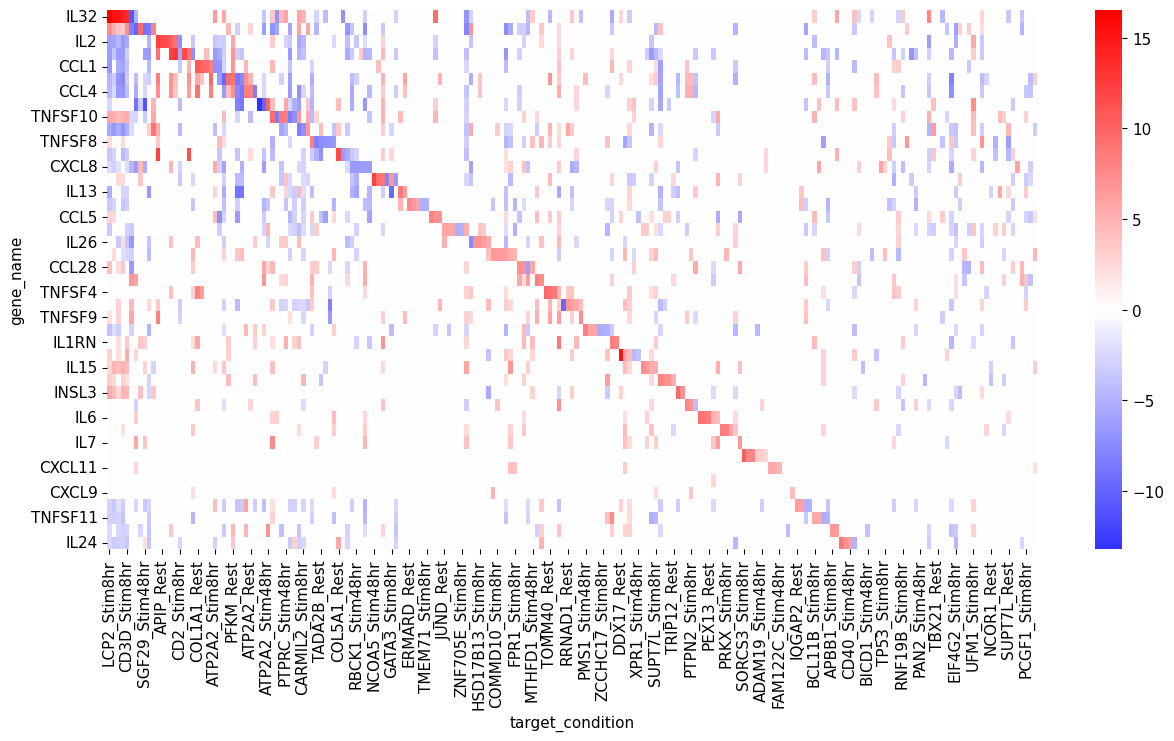

<Axes: xlabel='target_condition', ylabel='gene_name'>

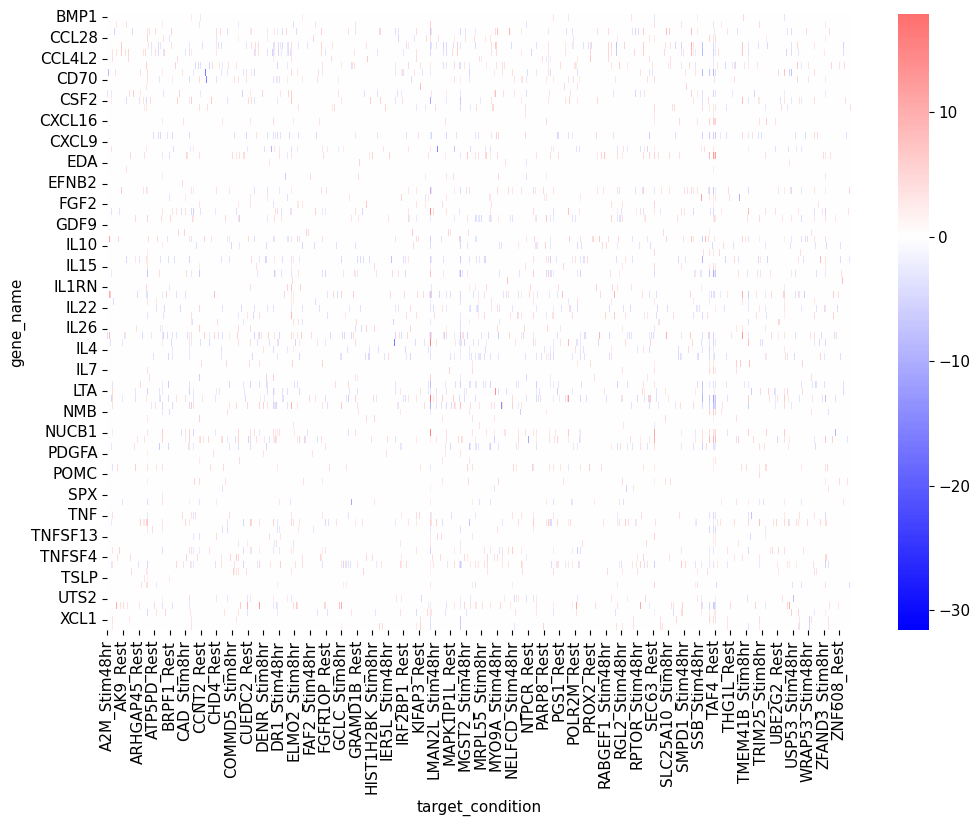

In [ ]:

sns.heatmap(pl_df, center=0, cmap='bwr')